# 1. Introduction

## 1.1 Contexte

Notebook utilisé pour améliorer modèle de ML via GridSearchCV suite à EDA Vdef (notebook 1)

Dans ce notebook, prediction de la target TotalGHGEmissions en 3 étapes:

V1: baseline (regression linéaire avec KNN Imputer pour l'ENERGYSTARScore

V2: améliorations du modèle via:
- passage au log de la target et des features dont la distribution n'est pas normale est excentrée 'sur la droite'
- GridSerachCV permettant de trouver les meilleurs scalers, estimateurs et hyperparamètres
- Feature selection avec SHAP pour exclure certaines features peu ou pas pertinentes

V3: Ajout de nouvelles variables (Feature Engineering) permettant d'améliorer le modèle

Metriques utilisées: R² MAE et MSE

## 1.2 Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import scipy.stats as stats
import pingouin as pg
import seaborn as sns

sns.set()
import missingno as msno
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import shap

shap.initjs()

## 1.3 Fonctions utiles / Set up

In [11]:
def result(grid, log_target=0, transf_feat=0, features=""):
    """Fonction retournant un dataframe res recensant les différents résultats du GridSearchCv passé en fonction des paramétres utilisés"""
    res = pd.DataFrame(grid.cv_results_).round(2)
    cols = [i for i in res.columns if "split" not in i]
    res = res.loc[:, cols]
    ###

    res["log_target"] = log_target
    res["transf_feat"] = transf_feat
    res["features"] = features

    ###

    return res.sort_values("rank_test_r2", ascending=True)

In [12]:
pd.set_option("display.max_columns", None)

In [13]:
DISPLAY = True

## 1.4 Datas

In [14]:
df1 = pd.read_csv("dataV1.csv")
df1.shape

(1609, 12)

In [15]:
df2 = pd.read_csv("dataV2.csv")
df2.shape

(1609, 15)

In [16]:
df3 = pd.read_csv("dataV3.csv")
df3.shape

(1609, 16)

In [17]:
df = pd.read_csv("data.csv")
df.shape

(1609, 22)

## 1.5 Structure

In [18]:
df1.head()

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),TotalGHGEmissions,ENERGYSTARScore
0,Hotel,47.61220,-122.33799,1927,DOWNTOWN,1.0,12,0,88434,7456910.0,249.98,60.0
1,Hotel,47.61317,-122.33393,1996,DOWNTOWN,1.0,11,15064,88502,8664479.0,295.86,61.0
2,Hotel,47.61393,-122.33810,1969,DOWNTOWN,1.0,41,196718,759392,73937112.0,2089.28,43.0
3,Hotel,47.61412,-122.33664,1926,DOWNTOWN,1.0,10,0,61320,6946800.5,286.43,56.0
4,Hotel,47.61375,-122.34047,1980,DOWNTOWN,1.0,18,62000,113580,14656503.0,505.01,75.0


In [19]:
df2.head()

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,Neighborhood,NumberofBuildings,NumberofFloors,has_parking,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),Steam_use,Electricity_use,Gas_use,TotalGHGEmissions,ENERGYSTARScore
0,Hotel,47.61220,-122.33799,1927,DOWNTOWN,1.0,12,0,88434,7456910.0,1,1,1,249.98,60.0
1,Hotel,47.61317,-122.33393,1996,DOWNTOWN,1.0,11,1,88502,8664479.0,0,1,1,295.86,61.0
2,Hotel,47.61393,-122.33810,1969,DOWNTOWN,1.0,41,1,759392,73937112.0,1,1,1,2089.28,43.0
3,Hotel,47.61412,-122.33664,1926,DOWNTOWN,1.0,10,0,61320,6946800.5,1,1,1,286.43,56.0
4,Hotel,47.61375,-122.34047,1980,DOWNTOWN,1.0,18,1,113580,14656503.0,0,1,1,505.01,75.0


In [20]:
df3.head()

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),TotalGHGEmissions,ENERGYSTARScore,superfice/etage,superfice/batiment,Parking_pct,pct_gaz,pct_elec,pct_steam
0,Hotel,47.61220,-122.33799,1927,1.0,12,88434,7456910.0,249.98,60.0,7369.500000,88434.0,0.000000,0.2,0.5,0.3
1,Hotel,47.61317,-122.33393,1996,1.0,11,88502,8664479.0,295.86,61.0,8045.636364,88502.0,0.145453,0.6,0.4,0.0
2,Hotel,47.61393,-122.33810,1969,1.0,41,759392,73937112.0,2089.28,43.0,18521.756098,759392.0,0.205748,0.0,0.7,0.3
3,Hotel,47.61412,-122.33664,1926,1.0,10,61320,6946800.5,286.43,56.0,6132.000000,61320.0,0.000000,0.3,0.4,0.3
4,Hotel,47.61375,-122.34047,1980,1.0,18,113580,14656503.0,505.01,75.0,6310.000000,113580.0,0.353115,0.6,0.4,0.0


# 2. Baseline(V1): Regression lineaire avec imputation des NaN par KNNImputer sans scaler

## 2.1 Séparation du jeu de données (feature: X / target:y)

Pour l'estimateur qui nous servira de base:
- récupération du ds dataV1 (cf notebook 1) => df1
- je ne prends pas en compte les données catégorielles. Elles seront transformées en V2 en var quantitative (OneHotEncoder) pour l'amélioration du modèle

In [21]:
X = df1.drop(["SiteEnergyUseWN(kBtu)", "TotalGHGEmissions"], axis=1).select_dtypes(
    include=np.number
)
X

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore
0,47.61220,-122.33799,1927,1.0,12,0,88434,60.0
1,47.61317,-122.33393,1996,1.0,11,15064,88502,61.0
2,47.61393,-122.33810,1969,1.0,41,196718,759392,43.0
3,47.61412,-122.33664,1926,1.0,10,0,61320,56.0
4,47.61375,-122.34047,1980,1.0,18,62000,113580,75.0
...,...,...,...,...,...,...,...,...
1604,47.62497,-122.33883,2015,1.0,6,85028,260262,NaN
1605,47.66127,-122.31256,1962,1.0,1,0,68072,NaN
1606,47.70541,-122.32232,2005,1.0,1,0,20616,NaN
1607,47.63228,-122.31574,1912,1.0,1,0,23445,NaN


Dans ce notebook la target sera 'TotalGHGEmissions'

In [22]:
y = df["TotalGHGEmissions"]
y

0        249.98
1        295.86
2       2089.28
3        286.43
4        505.01
         ...   
1604    1000.06
1605      22.17
1606       4.44
1607     259.22
1608      60.81
Name: TotalGHGEmissions, Length: 1609, dtype: float64

## 2.2 Entrainement de modèle via GridSearchCV / pipeline

Pour le pipeline:
- transformer: N/A
- imputer=KNNImputer()
- scaler: N/A
- estimator = LinearRegression()

In [23]:
pipeline = Pipeline([("imputer", KNNImputer()), ("estimator", LinearRegression())])
pipeline

Pipeline(steps=[('imputer', KNNImputer()), ('estimator', LinearRegression())])

gridsearch sur 10 folds...

In [24]:
grid = GridSearchCV(
    pipeline,
    {},
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)

In [25]:
grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('estimator', LinearRegression())]),
             n_jobs=-1, param_grid={}, refit='r2', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'),
             verbose=2)

In [26]:
grid.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('estimator', LinearRegression())]),
             n_jobs=-1, param_grid={}, refit='r2', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'),
             verbose=2)

In [27]:
res = result(grid)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
0,0.1,0.01,0.02,0.0,{},-0.4,0.94,1,0.3,0.02,-202.55,102.43,1,-191.78,22.81,-397798.0,692204.15,1,-359516.24,74298.75,0,0,


Pour cette baseline, le coeff de determination R² est encore plus mauvais que lorsque la target est la consommation d'énergie(R²=-0.4

Plusieurs pistes pour améliorer ce modèle:
- améliorer le dataset (transformation des données, scaling, feature engineering)
- trouver un meilleur estimateur, et trouver les meilleurs hyperparamètres

# 3. Amélioration du modèle 
- en comparant différents scalers et différents estimateurs
- en modifiant les données à la source
- en cherchant les meilleurs hyperparamétres

## 3.1 Recherche via GridSearch d'un scaler et d'un modèle qui amèliore les résultats

In [28]:
pipeline = Pipeline(
    [
        ("imputer", KNNImputer()),
        ("scaler", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
pipeline

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('estimator', LinearRegression())])

In [29]:
param_grid = {
    "scaler": [
        MinMaxScaler(),
        Normalizer(),
        RobustScaler(),
        StandardScaler(),
        "passthrough",
    ],
    "estimator": [
        LinearRegression(),
        SGDRegressor(),
        Ridge(),
        Lasso(),
        RandomForestRegressor(),
        KNeighborsRegressor(),
        SVR(),
    ],
}

In [30]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)
grid.fit(X, y)
res = result(grid)
res.head(10)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
28,0.10,0.01,0.03,0.01,KNeighborsRegressor(),StandardScaler(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.09,0.42,1,0.56,0.04,-161.11,114.69,6,-121.76,8.64,-386818.01,748545.49,1,-220331.33,36295.87,0,0,
25,0.08,0.00,0.02,0.00,KNeighborsRegressor(),MinMaxScaler(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.03,0.42,2,0.49,0.04,-162.58,111.25,9,-125.02,9.80,-421285.91,818801.93,18,-256694.59,43627.55,0,0,
34,0.31,0.05,0.06,0.02,SVR(),passthrough,"{'estimator': SVR(), 'scaler': 'passthrough'}",0.00,0.05,3,0.01,0.00,-146.61,124.49,1,-145.27,13.33,-507858.09,934304.81,26,-506022.99,102654.44,0,0,
11,0.10,0.01,0.02,0.00,Ridge(),Normalizer(),"{'estimator': Ridge(), 'scaler': Normalizer()}",-0.03,0.16,4,0.05,0.00,-189.33,104.74,17,-187.20,17.99,-491489.53,907983.99,25,-485173.59,98600.17,0,0,
33,0.33,0.01,0.07,0.00,SVR(),StandardScaler(),"{'estimator': SVR(), 'scaler': StandardScaler()}",-0.04,0.07,5,-0.02,0.00,-154.09,130.21,2,-152.13,14.24,-518761.88,946419.80,28,-517450.30,104417.60,0,0,
30,0.35,0.01,0.07,0.00,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",-0.05,0.08,6,-0.02,0.00,-157.76,132.13,3,-155.74,14.45,-522522.45,949534.99,29,-521156.94,104664.08,0,0,
16,0.10,0.01,0.02,0.00,Lasso(),Normalizer(),"{'estimator': Lasso(), 'scaler': Normalizer()}",-0.06,0.24,7,0.06,0.00,-199.21,106.09,20,-196.68,20.63,-487863.85,899851.30,24,-478767.49,97238.49,0,0,
32,0.32,0.01,0.07,0.01,SVR(),RobustScaler(),"{'estimator': SVR(), 'scaler': RobustScaler()}",-0.06,0.07,8,-0.03,0.00,-158.33,132.77,4,-156.85,14.62,-525592.49,953898.66,30,-524772.65,105435.46,0,0,
31,0.35,0.01,0.07,0.00,SVR(),Normalizer(),"{'estimator': SVR(), 'scaler': Normalizer()}",-0.07,0.08,9,-0.03,0.00,-159.54,133.24,5,-158.16,14.76,-526397.93,954438.46,31,-525608.96,105509.91,0,0,
5,0.27,0.04,0.02,0.01,SGDRegressor(),MinMaxScaler(),"{'estimator': SGDRegressor(), 'scaler': MinMax...",-0.15,0.62,10,0.27,0.02,-189.18,96.06,16,-177.48,20.28,-408927.20,733469.19,15,-370299.43,75715.38,0,0,


Amélioration sensible (KNN et Standard Scaler): R² passe de -0.4 à 0.09 mais résultat très faible 

### 3.1.1 Création d'un dataframe dédié (RES) permettant le suivi des résultats selon différents paramètres

Création d'un df permettant le recensement de tous les résultats des <> GridSearchCV en précisant dans 3 colonnes, les transformations appliquées:

=> log_target= 1 si la target a été passée au log, 0 sinon

=> transf: indique si les features ont été passées au log (1) ou non (0)

=> features: indique les eventuelles transformations appliquées au features 

In [31]:
RES = pd.DataFrame()

In [32]:
RES = pd.concat([RES, res], axis=0, ignore_index=True)
RES.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
0,0.10,0.01,0.03,0.01,KNeighborsRegressor(),StandardScaler(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.09,0.42,1,0.56,0.04,-161.11,114.69,6,-121.76,8.64,-386818.01,748545.49,1,-220331.33,36295.87,0,0,
1,0.08,0.00,0.02,0.00,KNeighborsRegressor(),MinMaxScaler(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.03,0.42,2,0.49,0.04,-162.58,111.25,9,-125.02,9.80,-421285.91,818801.93,18,-256694.59,43627.55,0,0,
2,0.31,0.05,0.06,0.02,SVR(),passthrough,"{'estimator': SVR(), 'scaler': 'passthrough'}",0.00,0.05,3,0.01,0.00,-146.61,124.49,1,-145.27,13.33,-507858.09,934304.81,26,-506022.99,102654.44,0,0,
3,0.10,0.01,0.02,0.00,Ridge(),Normalizer(),"{'estimator': Ridge(), 'scaler': Normalizer()}",-0.03,0.16,4,0.05,0.00,-189.33,104.74,17,-187.20,17.99,-491489.53,907983.99,25,-485173.59,98600.17,0,0,
4,0.33,0.01,0.07,0.00,SVR(),StandardScaler(),"{'estimator': SVR(), 'scaler': StandardScaler()}",-0.04,0.07,5,-0.02,0.00,-154.09,130.21,2,-152.13,14.24,-518761.88,946419.80,28,-517450.30,104417.60,0,0,
5,0.35,0.01,0.07,0.00,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",-0.05,0.08,6,-0.02,0.00,-157.76,132.13,3,-155.74,14.45,-522522.45,949534.99,29,-521156.94,104664.08,0,0,
6,0.10,0.01,0.02,0.00,Lasso(),Normalizer(),"{'estimator': Lasso(), 'scaler': Normalizer()}",-0.06,0.24,7,0.06,0.00,-199.21,106.09,20,-196.68,20.63,-487863.85,899851.30,24,-478767.49,97238.49,0,0,
7,0.32,0.01,0.07,0.01,SVR(),RobustScaler(),"{'estimator': SVR(), 'scaler': RobustScaler()}",-0.06,0.07,8,-0.03,0.00,-158.33,132.77,4,-156.85,14.62,-525592.49,953898.66,30,-524772.65,105435.46,0,0,
8,0.35,0.01,0.07,0.00,SVR(),Normalizer(),"{'estimator': SVR(), 'scaler': Normalizer()}",-0.07,0.08,9,-0.03,0.00,-159.54,133.24,5,-158.16,14.76,-526397.93,954438.46,31,-525608.96,105509.91,0,0,
9,0.27,0.04,0.02,0.01,SGDRegressor(),MinMaxScaler(),"{'estimator': SGDRegressor(), 'scaler': MinMax...",-0.15,0.62,10,0.27,0.02,-189.18,96.06,16,-177.48,20.28,-408927.20,733469.19,15,-370299.43,75715.38,0,0,


## 3.2 Amélioration du modèle en passant les variables au log

In [33]:
df1_log = df1.copy()

In [34]:
df1_log.shape

(1609, 12)

col à passer au log (d'après distribution des différentes variables/target vues dans le notebook EDA): 

In [35]:
df1_log.columns

Index(['PrimaryPropertyType', 'Latitude', 'Longitude', 'YearBuilt',
       'Neighborhood', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SiteEnergyUseWN(kBtu)',
       'TotalGHGEmissions', 'ENERGYSTARScore'],
      dtype='object')

In [36]:
col_log = [
    "TotalGHGEmissions",
    "PropertyGFABuilding(s)",
    "PropertyGFAParking",
    "NumberofBuildings",
    "NumberofFloors",
]
col_log

['TotalGHGEmissions',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'NumberofBuildings',
 'NumberofFloors']

In [37]:
for col in col_log:
    df1_log[col] = np.log1p(df1[col])
df1_log

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),TotalGHGEmissions,ENERGYSTARScore
0,Hotel,47.61220,-122.33799,1927,DOWNTOWN,0.693147,2.564949,0.000000,11.390023,7.456910e+06,5.525373,60.0
1,Hotel,47.61317,-122.33393,1996,DOWNTOWN,0.693147,2.484907,9.620129,11.390792,8.664479e+06,5.693261,61.0
2,Hotel,47.61393,-122.33810,1969,DOWNTOWN,0.693147,3.737670,12.189532,13.540275,7.393711e+07,7.645053,43.0
3,Hotel,47.61412,-122.33664,1926,DOWNTOWN,0.693147,2.397895,0.000000,11.023878,6.946800e+06,5.660979,56.0
4,Hotel,47.61375,-122.34047,1980,DOWNTOWN,0.693147,2.944439,11.034906,11.640272,1.465650e+07,6.226556,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,47.62497,-122.33883,2015,LAKE UNION,0.693147,1.945910,11.350748,12.469448,4.107860e+07,6.908815,NaN
1605,University,47.66127,-122.31256,1962,NORTHEAST,0.693147,0.693147,0.000000,11.128336,3.180819e+06,3.142858,NaN
1606,Entertainment,47.70541,-122.32232,2005,NORTH,0.693147,0.693147,0.000000,9.933871,6.369655e+05,1.693779,NaN
1607,Entertainment,47.63228,-122.31574,1912,EAST,0.693147,0.693147,0.000000,10.062455,6.716330e+06,5.561527,NaN


In [38]:
df1_log.describe()

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),TotalGHGEmissions,ENERGYSTARScore
count,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1.609000e+03,1609.000000,1073.000000
mean,47.615490,-122.332787,1961.587943,0.724293,1.346497,2.058859,10.982371,8.294142e+06,4.012068,65.461323
std,0.048003,0.024352,32.836564,0.196692,0.643619,4.204535,0.892582,2.237632e+07,1.448337,28.519642
min,47.499170,-122.411820,1900.000000,0.693147,0.693147,0.000000,9.903538,1.726000e+04,-1.609438,1.000000
25%,47.585130,-122.342740,1930.000000,0.693147,0.693147,0.000000,10.268165,1.376059e+06,3.075467,48.000000
50%,47.612200,-122.332890,1965.000000,0.693147,1.098612,0.000000,10.772687,2.789899e+06,3.946618,73.000000
75%,47.649090,-122.321800,1989.000000,0.693147,1.609438,0.000000,11.472062,7.378420e+06,4.979557,89.000000
max,47.733870,-122.258640,2015.000000,3.332205,4.343805,13.147269,14.603968,4.716139e+08,9.733410,100.000000


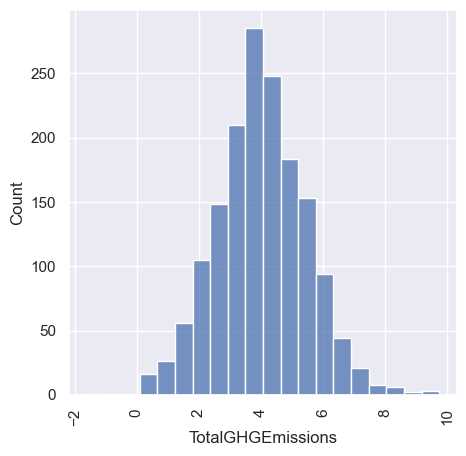

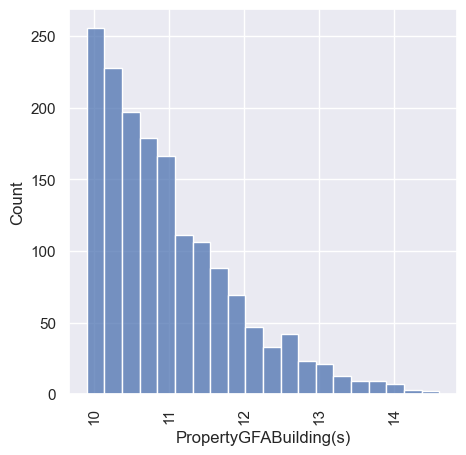

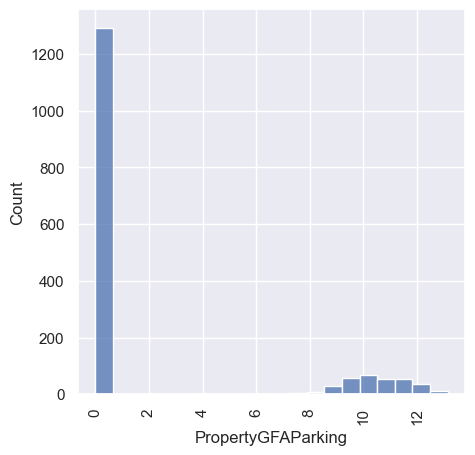

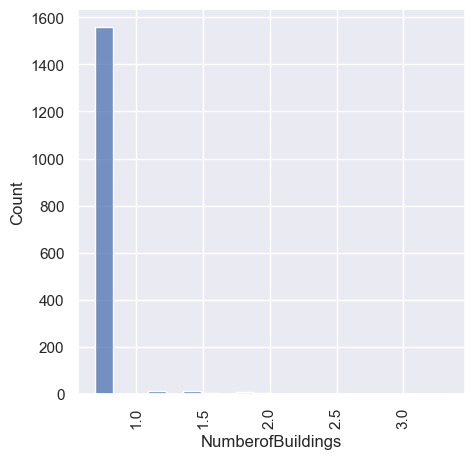

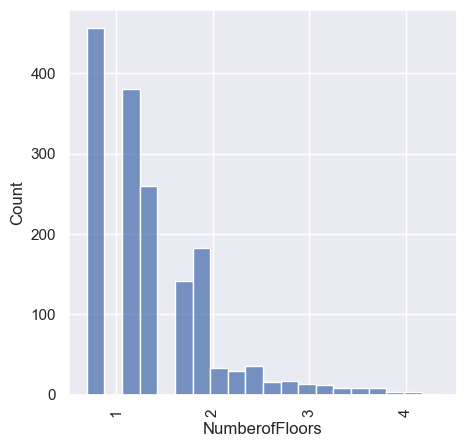

In [39]:
for col in col_log:
    plt.figure(figsize=(5, 5))  # ,constrained_layout=True)
    # plt.suptitle("Distribution de la surface par étage", size=20, y=1)
    plt.xticks(rotation=90)
    sns.histplot(df1_log[col], bins=20)  # , stat='percent' #, kde=True)

### 3.2.1 GridSearch sur base de df1_log

#### 3.2.1.1 Reconstitution des dataset X_log et y_log

In [40]:
X_log = df1_log.drop(
    ["SiteEnergyUseWN(kBtu)", "TotalGHGEmissions"], axis=1
).select_dtypes(include=np.number)
X_log

,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore
0,47.61220,-122.33799,1927,0.693147,2.564949,0.000000,11.390023,60.0
1,47.61317,-122.33393,1996,0.693147,2.484907,9.620129,11.390792,61.0
2,47.61393,-122.33810,1969,0.693147,3.737670,12.189532,13.540275,43.0
3,47.61412,-122.33664,1926,0.693147,2.397895,0.000000,11.023878,56.0
4,47.61375,-122.34047,1980,0.693147,2.944439,11.034906,11.640272,75.0
...,...,...,...,...,...,...,...,...
1604,47.62497,-122.33883,2015,0.693147,1.945910,11.350748,12.469448,NaN
1605,47.66127,-122.31256,1962,0.693147,0.693147,0.000000,11.128336,NaN
1606,47.70541,-122.32232,2005,0.693147,0.693147,0.000000,9.933871,NaN
1607,47.63228,-122.31574,1912,0.693147,0.693147,0.000000,10.062455,NaN


In [41]:
y_log = df1_log["TotalGHGEmissions"]
y_log.size

1609

#### 3.2.1.2 GridSearchCv

Essayons de voir si certains estimateurs se démarquent...
D'abord avec uniquement target au log...

In [42]:
grid.fit(X, y_log)
res = result(grid, log_target=1, transf_feat=0, features="")
res.head(10)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
22,1.14,0.01,0.03,0.00,RandomForestRegressor(),RobustScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.28,0.07,1,0.92,0.00,-0.87,0.05,1,-0.32,0.00,-1.20,0.15,1,-0.16,0.00,1,0,
20,1.15,0.03,0.03,0.00,RandomForestRegressor(),MinMaxScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.28,0.08,2,0.92,0.00,-0.87,0.05,3,-0.32,0.00,-1.21,0.14,2,-0.16,0.00,1,0,
24,1.20,0.09,0.04,0.01,RandomForestRegressor(),passthrough,"{'estimator': RandomForestRegressor(), 'scaler...",0.27,0.08,3,0.92,0.00,-0.87,0.05,2,-0.32,0.00,-1.21,0.16,3,-0.16,0.00,1,0,
23,1.16,0.02,0.03,0.01,RandomForestRegressor(),StandardScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.27,0.08,4,0.92,0.00,-0.87,0.05,4,-0.32,0.00,-1.21,0.13,4,-0.16,0.00,1,0,
33,0.33,0.00,0.07,0.01,SVR(),StandardScaler(),"{'estimator': SVR(), 'scaler': StandardScaler()}",0.22,0.08,5,0.47,0.02,-0.90,0.07,5,-0.80,0.01,-1.31,0.22,5,-1.11,0.02,1,0,
21,1.40,0.03,0.03,0.00,RandomForestRegressor(),Normalizer(),"{'estimator': RandomForestRegressor(), 'scaler...",0.20,0.09,6,0.91,0.00,-0.93,0.06,7,-0.34,0.00,-1.34,0.16,6,-0.18,0.00,1,0,
34,0.31,0.05,0.06,0.02,SVR(),passthrough,"{'estimator': SVR(), 'scaler': 'passthrough'}",0.19,0.06,7,0.38,0.02,-0.92,0.06,6,-0.90,0.01,-1.36,0.19,7,-1.30,0.02,1,0,
30,0.35,0.01,0.07,0.01,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.17,0.11,8,0.39,0.02,-0.93,0.09,8,-0.88,0.01,-1.38,0.24,8,-1.27,0.02,1,0,
1,0.14,0.03,0.02,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.17,0.07,9,0.36,0.02,-0.94,0.07,9,-0.92,0.01,-1.39,0.22,9,-1.35,0.02,1,0,
26,0.10,0.01,0.02,0.00,KNeighborsRegressor(),Normalizer(),"{'estimator': KNeighborsRegressor(), 'scaler':...",0.11,0.09,10,0.54,0.02,-0.98,0.05,10,-0.78,0.01,-1.48,0.16,10,-0.96,0.02,1,0,


En passant la target au log, le R² passe de 0.09 à 0.28 (RandomForest avec StandardScaler)

In [43]:
RES = pd.concat([RES, res], axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
35,1.14,0.01,0.03,0.00,RandomForestRegressor(),RobustScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.28,0.07,1,0.92,0.00,-0.87,0.05,1,-0.32,0.00,-1.20,0.15,1,-0.16,0.00,1,0,
36,1.15,0.03,0.03,0.00,RandomForestRegressor(),MinMaxScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.28,0.08,2,0.92,0.00,-0.87,0.05,3,-0.32,0.00,-1.21,0.14,2,-0.16,0.00,1,0,
38,1.16,0.02,0.03,0.01,RandomForestRegressor(),StandardScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.27,0.08,4,0.92,0.00,-0.87,0.05,4,-0.32,0.00,-1.21,0.13,4,-0.16,0.00,1,0,
37,1.20,0.09,0.04,0.01,RandomForestRegressor(),passthrough,"{'estimator': RandomForestRegressor(), 'scaler...",0.27,0.08,3,0.92,0.00,-0.87,0.05,2,-0.32,0.00,-1.21,0.16,3,-0.16,0.00,1,0,
39,0.33,0.00,0.07,0.01,SVR(),StandardScaler(),"{'estimator': SVR(), 'scaler': StandardScaler()}",0.22,0.08,5,0.47,0.02,-0.90,0.07,5,-0.80,0.01,-1.31,0.22,5,-1.11,0.02,1,0,


Puis en passant les features au log...

In [44]:
grid.fit(X_log, y_log)
res = result(grid, log_target=1, transf_feat=1, features="log")
res.head(10)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
1,0.14,0.02,0.03,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.28,0.09,1,0.44,0.02,-0.88,0.06,4,-0.87,0.01,-1.20,0.19,1,-1.17,0.02,1,1,log
14,0.13,0.01,0.03,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.27,0.09,2,0.43,0.02,-0.89,0.06,7,-0.87,0.01,-1.22,0.20,2,-1.18,0.02,1,1,log
10,0.13,0.01,0.02,0.01,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.27,0.09,3,0.43,0.02,-0.89,0.06,9,-0.87,0.01,-1.22,0.20,3,-1.18,0.02,1,1,log
13,0.13,0.01,0.02,0.01,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.27,0.09,4,0.43,0.02,-0.89,0.06,10,-0.87,0.01,-1.22,0.20,5,-1.18,0.02,1,1,log
12,0.13,0.01,0.02,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.27,0.09,5,0.43,0.02,-0.89,0.06,8,-0.87,0.01,-1.22,0.20,4,-1.18,0.02,1,1,log
0,0.13,0.01,0.02,0.01,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",0.27,0.09,6,0.43,0.02,-0.89,0.06,11,-0.87,0.01,-1.22,0.20,6,-1.18,0.02,1,1,log
2,0.13,0.02,0.02,0.00,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",0.27,0.09,7,0.43,0.02,-0.89,0.06,12,-0.87,0.01,-1.22,0.20,7,-1.18,0.02,1,1,log
3,0.12,0.01,0.02,0.01,LinearRegression(),StandardScaler(),"{'estimator': LinearRegression(), 'scaler': St...",0.27,0.09,8,0.43,0.02,-0.89,0.06,13,-0.87,0.01,-1.22,0.20,8,-1.18,0.02,1,1,log
4,0.13,0.02,0.02,0.01,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",0.27,0.09,9,0.43,0.02,-0.89,0.06,14,-0.87,0.01,-1.22,0.20,9,-1.18,0.02,1,1,log
7,0.13,0.01,0.02,0.01,SGDRegressor(),RobustScaler(),"{'estimator': SGDRegressor(), 'scaler': Robust...",0.27,0.09,10,0.43,0.02,-0.88,0.06,6,-0.87,0.01,-1.22,0.20,10,-1.19,0.02,1,1,log


La mise au log des features fait baisser la RandomForest mais augmente significativement le R² d'autres modéles:

=> Pour linearReg R² passe de 0.11 à 0.28


In [45]:
RES = pd.concat([RES, res], axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
36,1.15,0.03,0.03,0.00,RandomForestRegressor(),MinMaxScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.28,0.08,2,0.92,0.00,-0.87,0.05,3,-0.32,0.00,-1.21,0.14,2,-0.16,0.00,1,0,
70,0.14,0.02,0.03,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.28,0.09,1,0.44,0.02,-0.88,0.06,4,-0.87,0.01,-1.20,0.19,1,-1.17,0.02,1,1,log
35,1.14,0.01,0.03,0.00,RandomForestRegressor(),RobustScaler(),"{'estimator': RandomForestRegressor(), 'scaler...",0.28,0.07,1,0.92,0.00,-0.87,0.05,1,-0.32,0.00,-1.20,0.15,1,-0.16,0.00,1,0,
80,0.13,0.02,0.03,0.01,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",0.27,0.09,11,0.43,0.02,-0.89,0.06,17,-0.87,0.01,-1.23,0.20,11,-1.18,0.02,1,1,log
37,1.20,0.09,0.04,0.01,RandomForestRegressor(),passthrough,"{'estimator': RandomForestRegressor(), 'scaler...",0.27,0.08,3,0.92,0.00,-0.87,0.05,2,-0.32,0.00,-1.21,0.16,3,-0.16,0.00,1,0,


## 3.4 Amélioration du modèle en encodant les valeurs catégorielles

Dans le pipeline, création d'un transformer qui servira à encoder les variables catégorielles via OneHotEncoder 

### 3.4.1 Reconstitution du dataset X_log avec les variables catégorielles

In [46]:
X_log = df1_log.drop(
    ["SiteEnergyUseWN(kBtu)", "TotalGHGEmissions", "Neighborhood"], axis=1
)
X_log

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore
0,Hotel,47.61220,-122.33799,1927,0.693147,2.564949,0.000000,11.390023,60.0
1,Hotel,47.61317,-122.33393,1996,0.693147,2.484907,9.620129,11.390792,61.0
2,Hotel,47.61393,-122.33810,1969,0.693147,3.737670,12.189532,13.540275,43.0
3,Hotel,47.61412,-122.33664,1926,0.693147,2.397895,0.000000,11.023878,56.0
4,Hotel,47.61375,-122.34047,1980,0.693147,2.944439,11.034906,11.640272,75.0
...,...,...,...,...,...,...,...,...,...
1604,Laboratory,47.62497,-122.33883,2015,0.693147,1.945910,11.350748,12.469448,NaN
1605,University,47.66127,-122.31256,1962,0.693147,0.693147,0.000000,11.128336,NaN
1606,Entertainment,47.70541,-122.32232,2005,0.693147,0.693147,0.000000,9.933871,NaN
1607,Entertainment,47.63228,-122.31574,1912,0.693147,0.693147,0.000000,10.062455,NaN


### 3.4.2 Adaptation du pipeline

In [47]:
cat_feat = X_log.select_dtypes(exclude=np.number).columns.to_list()
cat_feat

['PrimaryPropertyType']

In [48]:
num_feat = X_log.select_dtypes(include=np.number).columns.to_list()
num_feat

['Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ENERGYSTARScore']

Création d'un transformer dans le pipeline:

In [49]:
transformer = ColumnTransformer(
    transformers=[
        ("OneHot", OneHotEncoder(sparse=False), cat_feat),
        ("num", "passthrough", num_feat),
    ]
)
transformer

ColumnTransformer(transformers=[('OneHot', OneHotEncoder(sparse=False),
                                 ['PrimaryPropertyType']),
                                ('num', 'passthrough',
                                 ['Latitude', 'Longitude', 'YearBuilt',
                                  'NumberofBuildings', 'NumberofFloors',
                                  'PropertyGFAParking',
                                  'PropertyGFABuilding(s)',
                                  'ENERGYSTARScore'])])

In [50]:
pipeline = Pipeline(
    [
        ("preprocessor", transformer),
        ("imputer", KNNImputer()),
        ("scaler", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore'])])),
                ('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('estimator', LinearRegression())])

In [51]:
param_grid = {
    "scaler": [
        MinMaxScaler(),
        Normalizer(),
        RobustScaler(),
        StandardScaler(),
        "passthrough",
    ],
    "estimator": [
        LinearRegression(),
        SGDRegressor(),
        Ridge(),
        Lasso(),
        RandomForestRegressor(),
        KNeighborsRegressor(),
        SVR(),
    ],
}

In [52]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)
grid.fit(X_log, y_log)
res = result(grid, log_target=1, transf_feat=1, features="log + OneHot")
res.head(10)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
14,0.15,0.02,0.03,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.45,0.13,1,0.59,0.02,-0.75,0.10,2,-0.73,0.01,-0.91,0.21,1,-0.87,0.02,1,1,log + OneHot
1,0.18,0.04,0.03,0.00,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.45,0.13,2,0.59,0.02,-0.75,0.10,3,-0.73,0.01,-0.91,0.21,2,-0.86,0.02,1,1,log + OneHot
12,0.15,0.01,0.03,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.45,0.14,3,0.59,0.02,-0.75,0.10,6,-0.73,0.01,-0.91,0.21,3,-0.87,0.02,1,1,log + OneHot
10,0.15,0.01,0.03,0.01,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.45,0.14,4,0.59,0.02,-0.75,0.09,10,-0.73,0.01,-0.91,0.21,4,-0.87,0.02,1,1,log + OneHot
13,0.15,0.01,0.03,0.00,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.45,0.14,5,0.59,0.02,-0.75,0.10,5,-0.73,0.01,-0.91,0.21,5,-0.87,0.02,1,1,log + OneHot
4,0.14,0.01,0.03,0.00,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",0.45,0.14,6,0.59,0.02,-0.75,0.10,4,-0.73,0.01,-0.91,0.21,6,-0.87,0.02,1,1,log + OneHot
0,0.16,0.04,0.02,0.00,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",0.45,0.14,7,0.59,0.02,-0.75,0.10,8,-0.73,0.01,-0.91,0.21,7,-0.87,0.02,1,1,log + OneHot
2,0.17,0.02,0.03,0.00,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",0.45,0.14,8,0.59,0.02,-0.75,0.10,9,-0.73,0.01,-0.91,0.21,8,-0.87,0.02,1,1,log + OneHot
3,0.15,0.01,0.03,0.01,LinearRegression(),StandardScaler(),"{'estimator': LinearRegression(), 'scaler': St...",0.45,0.14,9,0.59,0.02,-0.75,0.10,7,-0.73,0.01,-0.91,0.21,9,-0.87,0.02,1,1,log + OneHot
8,0.15,0.01,0.03,0.01,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",0.45,0.14,10,0.58,0.02,-0.75,0.10,11,-0.73,0.01,-0.92,0.21,10,-0.87,0.02,1,1,log + OneHot


Avec encodage des variables catégorielles (Usage du bâtiment et quartier), le coeff  R² passe de 0.27 à 0.45 pour:
- LinReg et Ridge avec <> scalers
- SGD Regression avec StandardScaler

In [53]:
RES = pd.concat([RES, res], axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
113,0.15,0.01,0.03,0.01,LinearRegression(),StandardScaler(),"{'estimator': LinearRegression(), 'scaler': St...",0.45,0.14,9,0.59,0.02,-0.75,0.10,7,-0.73,0.01,-0.91,0.21,9,-0.87,0.02,1,1,log + OneHot
109,0.15,0.01,0.03,0.00,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.45,0.14,5,0.59,0.02,-0.75,0.10,5,-0.73,0.01,-0.91,0.21,5,-0.87,0.02,1,1,log + OneHot
111,0.16,0.04,0.02,0.00,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",0.45,0.14,7,0.59,0.02,-0.75,0.10,8,-0.73,0.01,-0.91,0.21,7,-0.87,0.02,1,1,log + OneHot
112,0.17,0.02,0.03,0.00,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",0.45,0.14,8,0.59,0.02,-0.75,0.10,9,-0.73,0.01,-0.91,0.21,8,-0.87,0.02,1,1,log + OneHot
108,0.15,0.01,0.03,0.01,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.45,0.14,4,0.59,0.02,-0.75,0.09,10,-0.73,0.01,-0.91,0.21,4,-0.87,0.02,1,1,log + OneHot


## 3.5 Utlisation des features parking et type d'energie (en booléen)

Sur base du dataV2, constitué dans le notebook 1 dans lequel j'ai transformé la superficie du parking en indicateur 'has_parking?' et les conso de gaz, elec et steam en booléen

In [54]:
df2_log = df2.copy()

In [55]:
col_log

['TotalGHGEmissions',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'NumberofBuildings',
 'NumberofFloors']

Suppression de PropertyGFAParking' de la liste des features à passer au col


In [56]:
col_log = [
    "TotalGHGEmissions",
    "NumberofBuildings",
    "NumberofFloors",
    "PropertyGFABuilding(s)",
]

In [57]:
for col in col_log:
    df2_log[col] = np.log1p(df2[col])
df2_log

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,Neighborhood,NumberofBuildings,NumberofFloors,has_parking,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),Steam_use,Electricity_use,Gas_use,TotalGHGEmissions,ENERGYSTARScore
0,Hotel,47.61220,-122.33799,1927,DOWNTOWN,0.693147,2.564949,0,11.390023,7.456910e+06,1,1,1,5.525373,60.0
1,Hotel,47.61317,-122.33393,1996,DOWNTOWN,0.693147,2.484907,1,11.390792,8.664479e+06,0,1,1,5.693261,61.0
2,Hotel,47.61393,-122.33810,1969,DOWNTOWN,0.693147,3.737670,1,13.540275,7.393711e+07,1,1,1,7.645053,43.0
3,Hotel,47.61412,-122.33664,1926,DOWNTOWN,0.693147,2.397895,0,11.023878,6.946800e+06,1,1,1,5.660979,56.0
4,Hotel,47.61375,-122.34047,1980,DOWNTOWN,0.693147,2.944439,1,11.640272,1.465650e+07,0,1,1,6.226556,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,47.62497,-122.33883,2015,LAKE UNION,0.693147,1.945910,1,12.469448,4.107860e+07,0,1,1,6.908815,NaN
1605,University,47.66127,-122.31256,1962,NORTHEAST,0.693147,0.693147,0,11.128336,3.180819e+06,0,1,0,3.142858,NaN
1606,Entertainment,47.70541,-122.32232,2005,NORTH,0.693147,0.693147,0,9.933871,6.369655e+05,0,1,0,1.693779,NaN
1607,Entertainment,47.63228,-122.31574,1912,EAST,0.693147,0.693147,0,10.062455,6.716330e+06,0,1,1,5.561527,NaN


### 3.5.1 Adaptation du dataset X_log avec les nouvelles variables

In [58]:
X_log = df2_log.drop(
    ["SiteEnergyUseWN(kBtu)", "TotalGHGEmissions", "Neighborhood"], axis=1
)
X_log

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,has_parking,PropertyGFABuilding(s),Steam_use,Electricity_use,Gas_use,ENERGYSTARScore
0,Hotel,47.61220,-122.33799,1927,0.693147,2.564949,0,11.390023,1,1,1,60.0
1,Hotel,47.61317,-122.33393,1996,0.693147,2.484907,1,11.390792,0,1,1,61.0
2,Hotel,47.61393,-122.33810,1969,0.693147,3.737670,1,13.540275,1,1,1,43.0
3,Hotel,47.61412,-122.33664,1926,0.693147,2.397895,0,11.023878,1,1,1,56.0
4,Hotel,47.61375,-122.34047,1980,0.693147,2.944439,1,11.640272,0,1,1,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,47.62497,-122.33883,2015,0.693147,1.945910,1,12.469448,0,1,1,NaN
1605,University,47.66127,-122.31256,1962,0.693147,0.693147,0,11.128336,0,1,0,NaN
1606,Entertainment,47.70541,-122.32232,2005,0.693147,0.693147,0,9.933871,0,1,0,NaN
1607,Entertainment,47.63228,-122.31574,1912,0.693147,0.693147,0,10.062455,0,1,1,NaN


### 3.5.2 Adaptation du pipeline

In [59]:
num_feat = X_log.select_dtypes(include=np.number).columns.to_list()
num_feat

['Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'has_parking',
 'PropertyGFABuilding(s)',
 'Steam_use',
 'Electricity_use',
 'Gas_use',
 'ENERGYSTARScore']

In [60]:
transformer = ColumnTransformer(
    transformers=[
        ("OneHot", OneHotEncoder(sparse=False), cat_feat),
        ("num", "passthrough", num_feat),
    ]
)

In [61]:
pipeline = Pipeline(
    [
        ("preprocessor", transformer),
        ("imputer", KNNImputer()),
        ("scaler", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'has_parking',
                                                   'PropertyGFABuilding(s)',
                                                   'Steam_use',
                                                   'Electricity_use', 'Gas_use',
                                                   'ENERGYSTARScore'])])),
                ('imputer', KNNImput

In [62]:
param_grid

{'scaler': [MinMaxScaler(),
  Normalizer(),
  RobustScaler(),
  StandardScaler(),
  'passthrough'],
 'estimator': [LinearRegression(),
  SGDRegressor(),
  Ridge(),
  Lasso(),
  RandomForestRegressor(),
  KNeighborsRegressor(),
  SVR()]}

In [63]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)
grid.fit(X_log, y_log)
res = result(grid, log_target=1, transf_feat=1, features="log + OneHot + NRJ_bool")
res.head(10)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
30,0.42,0.02,0.08,0.01,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.69,0.04,1,0.79,0.01,-0.54,0.06,1,-0.47,0.01,-0.53,0.12,1,-0.44,0.01,1,1,log + OneHot + NRJ_bool
32,0.47,0.02,0.08,0.01,SVR(),RobustScaler(),"{'estimator': SVR(), 'scaler': RobustScaler()}",0.66,0.05,2,0.82,0.01,-0.57,0.07,2,-0.43,0.00,-0.58,0.15,2,-0.38,0.01,1,1,log + OneHot + NRJ_bool
14,0.15,0.02,0.03,0.00,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.65,0.06,3,0.74,0.01,-0.59,0.05,4,-0.57,0.01,-0.59,0.12,3,-0.54,0.01,1,1,log + OneHot + NRJ_bool
12,0.17,0.01,0.03,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.65,0.06,4,0.74,0.01,-0.59,0.05,5,-0.57,0.01,-0.59,0.12,4,-0.54,0.01,1,1,log + OneHot + NRJ_bool
10,0.15,0.01,0.03,0.01,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.65,0.06,5,0.74,0.01,-0.59,0.05,6,-0.57,0.01,-0.59,0.12,5,-0.54,0.01,1,1,log + OneHot + NRJ_bool
1,0.17,0.05,0.03,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.64,0.07,6,0.74,0.01,-0.59,0.06,7,-0.56,0.01,-0.61,0.14,6,-0.54,0.01,1,1,log + OneHot + NRJ_bool
13,0.15,0.01,0.03,0.01,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.64,0.07,7,0.74,0.01,-0.59,0.06,8,-0.57,0.01,-0.61,0.14,7,-0.54,0.01,1,1,log + OneHot + NRJ_bool
4,0.15,0.01,0.03,0.01,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",0.64,0.07,8,0.74,0.01,-0.59,0.06,9,-0.57,0.01,-0.61,0.14,8,-0.54,0.01,1,1,log + OneHot + NRJ_bool
0,0.16,0.04,0.02,0.00,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",0.64,0.07,9,0.74,0.01,-0.59,0.06,10,-0.57,0.01,-0.61,0.14,10,-0.54,0.01,1,1,log + OneHot + NRJ_bool
2,0.18,0.03,0.03,0.01,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",0.64,0.07,10,0.74,0.01,-0.59,0.06,11,-0.57,0.01,-0.61,0.14,9,-0.54,0.01,1,1,log + OneHot + NRJ_bool


Avec l'utilisation des type de conso des batiment le R² max passe de 0.45 à 0.69 (SVR avec MinMax)


In [64]:
RES = pd.concat([RES, res], axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
140,0.42,0.02,0.08,0.01,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.69,0.04,1,0.79,0.01,-0.54,0.06,1,-0.47,0.01,-0.53,0.12,1,-0.44,0.01,1,1,log + OneHot + NRJ_bool
141,0.47,0.02,0.08,0.01,SVR(),RobustScaler(),"{'estimator': SVR(), 'scaler': RobustScaler()}",0.66,0.05,2,0.82,0.01,-0.57,0.07,2,-0.43,0.00,-0.58,0.15,2,-0.38,0.01,1,1,log + OneHot + NRJ_bool
142,0.15,0.02,0.03,0.00,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.65,0.06,3,0.74,0.01,-0.59,0.05,4,-0.57,0.01,-0.59,0.12,3,-0.54,0.01,1,1,log + OneHot + NRJ_bool
143,0.17,0.01,0.03,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.65,0.06,4,0.74,0.01,-0.59,0.05,5,-0.57,0.01,-0.59,0.12,4,-0.54,0.01,1,1,log + OneHot + NRJ_bool
144,0.15,0.01,0.03,0.01,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.65,0.06,5,0.74,0.01,-0.59,0.05,6,-0.57,0.01,-0.59,0.12,5,-0.54,0.01,1,1,log + OneHot + NRJ_bool
151,0.17,0.02,0.03,0.01,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",0.64,0.07,12,0.74,0.01,-0.59,0.06,13,-0.57,0.01,-0.61,0.14,12,-0.54,0.01,1,1,log + OneHot + NRJ_bool
145,0.17,0.05,0.03,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.64,0.07,6,0.74,0.01,-0.59,0.06,7,-0.56,0.01,-0.61,0.14,6,-0.54,0.01,1,1,log + OneHot + NRJ_bool
146,0.15,0.01,0.03,0.01,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.64,0.07,7,0.74,0.01,-0.59,0.06,8,-0.57,0.01,-0.61,0.14,7,-0.54,0.01,1,1,log + OneHot + NRJ_bool
147,0.15,0.01,0.03,0.01,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",0.64,0.07,8,0.74,0.01,-0.59,0.06,9,-0.57,0.01,-0.61,0.14,8,-0.54,0.01,1,1,log + OneHot + NRJ_bool
149,0.18,0.03,0.03,0.01,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",0.64,0.07,10,0.74,0.01,-0.59,0.06,11,-0.57,0.01,-0.61,0.14,9,-0.54,0.01,1,1,log + OneHot + NRJ_bool


## 3.6 Amélioration des hyperparamètres

### 3.5.1 SVR 

In [65]:
param_grid = {
    "scaler": [
        MinMaxScaler(),
    ],
    "estimator": [
        SVR(),
    ],
    "estimator__epsilon": [0, 0.01, 0.05, 0.2],
    "estimator__C": [1, 2, 3, 5],
}

In [66]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)
grid.fit(X_log, y_log)
res = result(grid, log_target=1, transf_feat=1, features="log + OneHot + NRJ_bool")
res.head(5)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__C,param_estimator__epsilon,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
7,0.40,0.04,0.08,0.01,"SVR(C=2, epsilon=0.2)",2,0.2,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,1,0.80,0.01,-0.54,0.06,10,-0.46,0.01,-0.52,0.12,1,-0.41,0.01,1,1,log + OneHot + NRJ_bool
2,0.43,0.02,0.08,0.00,"SVR(C=2, epsilon=0.2)",1,0.05,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,2,0.79,0.01,-0.53,0.06,7,-0.47,0.01,-0.52,0.12,2,-0.44,0.01,1,1,log + OneHot + NRJ_bool
1,0.52,0.10,0.09,0.01,"SVR(C=2, epsilon=0.2)",1,0.01,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,3,0.79,0.01,-0.53,0.06,4,-0.47,0.01,-0.53,0.12,4,-0.44,0.01,1,1,log + OneHot + NRJ_bool
6,0.43,0.02,0.09,0.02,"SVR(C=2, epsilon=0.2)",2,0.05,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,4,0.80,0.01,-0.53,0.06,3,-0.45,0.01,-0.53,0.12,3,-0.42,0.01,1,1,log + OneHot + NRJ_bool
0,0.55,0.10,0.10,0.01,"SVR(C=2, epsilon=0.2)",1,0,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,5,0.79,0.01,-0.53,0.06,5,-0.47,0.01,-0.53,0.12,6,-0.45,0.01,1,1,log + OneHot + NRJ_bool


Pas d'amélioration

In [67]:
model = grid.best_estimator_
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'has_parking',
                                                   'PropertyGFABuilding(s)',
                                                   'Steam_use',
                                                   'Electricity_use', 'Gas_use',
                                                   'ENERGYSTARScore'])])),
                ('imputer', KNNImput

In [68]:
RES = pd.concat([RES, res], axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon
181,0.52,0.05,0.09,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,7,0.80,0.01,-0.53,0.06,2,-0.44,0.01,-0.53,0.12,7,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0
180,0.45,0.02,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,6,0.80,0.01,-0.53,0.06,1,-0.45,0.01,-0.53,0.12,5,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0.01
140,0.42,0.02,0.08,0.01,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.69,0.04,1,0.79,0.01,-0.54,0.06,1,-0.47,0.01,-0.53,0.12,1,-0.44,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN
175,0.40,0.04,0.08,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,1,0.80,0.01,-0.54,0.06,10,-0.46,0.01,-0.52,0.12,1,-0.41,0.01,1,1,log + OneHot + NRJ_bool,2,0.2
176,0.43,0.02,0.08,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,2,0.79,0.01,-0.53,0.06,7,-0.47,0.01,-0.52,0.12,2,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.05


### 3.5.2 Ridge

ajout de de l'hyperparamètre alpha dans le param_grid:

In [69]:
param_grid = {
    "scaler": [MinMaxScaler(), RobustScaler(), StandardScaler(), "passthrough"],
    "estimator": [
        Ridge(),
    ],
    "estimator__alpha": [5, 100, 200, 500],
}

In [70]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)
grid.fit(X_log, y_log)
res = result(grid, log_target=1, transf_feat=1, features="log + OneHot + NRJ_bool")
res.head(5)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__alpha,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
3,0.15,0.01,0.03,0.01,Ridge(alpha=5),5,passthrough,"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.65,0.05,1,0.74,0.01,-0.59,0.05,1,-0.57,0.01,-0.58,0.12,1,-0.55,0.01,1,1,log + OneHot + NRJ_bool
1,0.19,0.04,0.03,0.01,Ridge(alpha=5),5,RobustScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.65,0.05,2,0.74,0.01,-0.59,0.05,2,-0.57,0.01,-0.58,0.12,2,-0.55,0.01,1,1,log + OneHot + NRJ_bool
0,0.15,0.02,0.03,0.01,Ridge(alpha=5),5,MinMaxScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.65,0.05,3,0.74,0.01,-0.59,0.05,4,-0.57,0.01,-0.59,0.12,3,-0.55,0.01,1,1,log + OneHot + NRJ_bool
2,0.15,0.02,0.03,0.00,Ridge(alpha=5),5,StandardScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.64,0.07,4,0.74,0.01,-0.59,0.06,3,-0.57,0.01,-0.61,0.14,4,-0.54,0.01,1,1,log + OneHot + NRJ_bool
6,0.16,0.01,0.03,0.00,Ridge(alpha=5),100,StandardScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.63,0.06,5,0.74,0.01,-0.60,0.05,5,-0.57,0.01,-0.61,0.14,5,-0.55,0.01,1,1,log + OneHot + NRJ_bool


Pas d'amélioration

In [71]:
RES = pd.concat([RES, res], axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha
178,0.43,0.02,0.09,0.02,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,4,0.80,0.01,-0.53,0.06,3,-0.45,0.01,-0.53,0.12,3,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0.05,NaN
140,0.42,0.02,0.08,0.01,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.69,0.04,1,0.79,0.01,-0.54,0.06,1,-0.47,0.01,-0.53,0.12,1,-0.44,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN
180,0.45,0.02,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,6,0.80,0.01,-0.53,0.06,1,-0.45,0.01,-0.53,0.12,5,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0.01,NaN
181,0.52,0.05,0.09,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,7,0.80,0.01,-0.53,0.06,2,-0.44,0.01,-0.53,0.12,7,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0,NaN
182,0.40,0.03,0.07,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,8,0.79,0.01,-0.54,0.06,15,-0.48,0.01,-0.53,0.12,8,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.2,NaN


### 3.5.3 SGD regressor

In [72]:
param_grid = {
    "scaler": [MinMaxScaler(), "passthrough"],
    "estimator": [
        SGDRegressor(),
    ],
    "estimator__eta0": np.linspace(0.01, 0.5, 11),
}

In [73]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)
grid.fit(X_log, y_log)
res = result(grid, log_target=1, transf_feat=1, features="log + OneHot + NRJ_bool")
res.head(5)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__eta0,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
6,0.15,0.02,0.04,0.01,SGDRegressor(eta0=0.15700000000000003),0.157,MinMaxScaler(),{'estimator': SGDRegressor(eta0=0.157000000000...,0.65,0.05,1,0.74,0.01,-0.59,0.05,1,-0.58,0.01,-0.59,0.10,1,-0.55,0.02,1,1,log + OneHot + NRJ_bool
2,0.17,0.01,0.03,0.01,SGDRegressor(eta0=0.15700000000000003),0.059,MinMaxScaler(),{'estimator': SGDRegressor(eta0=0.157000000000...,0.65,0.06,2,0.74,0.01,-0.59,0.05,2,-0.57,0.01,-0.59,0.11,2,-0.55,0.01,1,1,log + OneHot + NRJ_bool
4,0.16,0.01,0.03,0.01,SGDRegressor(eta0=0.15700000000000003),0.108,MinMaxScaler(),{'estimator': SGDRegressor(eta0=0.157000000000...,0.64,0.06,3,0.74,0.01,-0.60,0.04,3,-0.58,0.01,-0.59,0.09,3,-0.55,0.02,1,1,log + OneHot + NRJ_bool
8,0.15,0.01,0.03,0.01,SGDRegressor(eta0=0.15700000000000003),0.206,MinMaxScaler(),{'estimator': SGDRegressor(eta0=0.157000000000...,0.64,0.06,4,0.73,0.02,-0.61,0.06,4,-0.58,0.01,-0.61,0.11,4,-0.56,0.03,1,1,log + OneHot + NRJ_bool
10,0.16,0.01,0.03,0.00,SGDRegressor(eta0=0.15700000000000003),0.255,MinMaxScaler(),{'estimator': SGDRegressor(eta0=0.157000000000...,0.63,0.06,5,0.73,0.02,-0.61,0.06,5,-0.58,0.01,-0.62,0.11,5,-0.56,0.03,1,1,log + OneHot + NRJ_bool


Pour leSGDRegressor le meilleur R² passe de 0.63 à 0.65

In [74]:
RES = pd.concat([RES, res], axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0
182,0.40,0.03,0.07,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,8,0.79,0.01,-0.54,0.06,15,-0.48,0.01,-0.53,0.12,8,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.2,NaN,NaN
180,0.45,0.02,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,6,0.80,0.01,-0.53,0.06,1,-0.45,0.01,-0.53,0.12,5,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0.01,NaN,NaN
181,0.52,0.05,0.09,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,7,0.80,0.01,-0.53,0.06,2,-0.44,0.01,-0.53,0.12,7,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0,NaN,NaN
176,0.43,0.02,0.08,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,2,0.79,0.01,-0.53,0.06,7,-0.47,0.01,-0.52,0.12,2,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.05,NaN,NaN
175,0.40,0.04,0.08,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,1,0.80,0.01,-0.54,0.06,10,-0.46,0.01,-0.52,0.12,1,-0.41,0.01,1,1,log + OneHot + NRJ_bool,2,0.2,NaN,NaN


### 3.5.3 Amélioration hyperparam pour RandomForest

In [75]:
param_grid = {
    "scaler": [
        MinMaxScaler(),
        Normalizer(),
        RobustScaler(),
        StandardScaler(),
        "passthrough",
    ],
    "estimator": [
        RandomForestRegressor(),
    ],
    "estimator__n_estimators": [
        200,
        300,
        500,
    ],
}

In [76]:
if DISPLAY:
    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=10,
        scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
        n_jobs=-1,
        verbose=2,
        return_train_score=True,
        refit="r2",
    )
    grid.fit(X_log, y_log)
    res = result(grid, log_target=1, transf_feat=1, features="log + OneHot + NRJ_bool")
res.head(5)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__n_estimators,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
11,11.09,0.30,0.13,0.03,RandomForestRegressor(n_estimators=500),500,Normalizer(),{'estimator': RandomForestRegressor(n_estimato...,0.63,0.04,1,0.96,0.0,-0.6,0.05,1,-0.22,0.0,-0.61,0.12,1,-0.08,0.0,1,1,log + OneHot + NRJ_bool
6,6.36,0.16,0.08,0.01,RandomForestRegressor(n_estimators=500),300,Normalizer(),{'estimator': RandomForestRegressor(n_estimato...,0.63,0.04,2,0.96,0.0,-0.6,0.05,2,-0.22,0.0,-0.62,0.11,2,-0.08,0.0,1,1,log + OneHot + NRJ_bool
1,4.24,0.15,0.06,0.00,RandomForestRegressor(n_estimators=500),200,Normalizer(),{'estimator': RandomForestRegressor(n_estimato...,0.63,0.04,3,0.96,0.0,-0.6,0.06,3,-0.22,0.0,-0.62,0.12,3,-0.08,0.0,1,1,log + OneHot + NRJ_bool
14,6.40,0.92,0.07,0.01,RandomForestRegressor(n_estimators=500),500,passthrough,{'estimator': RandomForestRegressor(n_estimato...,0.63,0.04,4,0.96,0.0,-0.6,0.06,4,-0.21,0.0,-0.63,0.13,4,-0.08,0.0,1,1,log + OneHot + NRJ_bool
13,8.05,0.28,0.11,0.02,RandomForestRegressor(n_estimators=500),500,StandardScaler(),{'estimator': RandomForestRegressor(n_estimato...,0.63,0.04,5,0.96,0.0,-0.6,0.06,7,-0.21,0.0,-0.63,0.13,5,-0.08,0.0,1,1,log + OneHot + NRJ_bool


Pas d'amélioration en fonction du nombre d'arbres choisi

In [77]:
RES = pd.concat([RES, res], axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0,param_estimator__n_estimators
182,0.40,0.03,0.07,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,8,0.79,0.01,-0.54,0.06,15,-0.48,0.01,-0.53,0.12,8,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.2,NaN,NaN,NaN
176,0.43,0.02,0.08,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,2,0.79,0.01,-0.53,0.06,7,-0.47,0.01,-0.52,0.12,2,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.05,NaN,NaN,NaN
184,0.51,0.04,0.10,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,10,0.81,0.01,-0.53,0.06,6,-0.44,0.01,-0.53,0.12,10,-0.40,0.01,1,1,log + OneHot + NRJ_bool,3,0.05,NaN,NaN,NaN
181,0.52,0.05,0.09,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,7,0.80,0.01,-0.53,0.06,2,-0.44,0.01,-0.53,0.12,7,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0,NaN,NaN,NaN
180,0.45,0.02,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,6,0.80,0.01,-0.53,0.06,1,-0.45,0.01,-0.53,0.12,5,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0.01,NaN,NaN,NaN


## 3.7 Conclusion: meilleur modèle

In [78]:
RES.sort_values("mean_test_r2", ascending=False).head(50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0,param_estimator__n_estimators
182,0.40,0.03,0.07,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,8,0.79,0.01,-0.54,0.06,15,-0.48,0.01,-0.53,0.12,8,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.2,NaN,NaN,NaN
176,0.43,0.02,0.08,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,2,0.79,0.01,-0.53,0.06,7,-0.47,0.01,-0.52,0.12,2,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.05,NaN,NaN,NaN
184,0.51,0.04,0.10,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,10,0.81,0.01,-0.53,0.06,6,-0.44,0.01,-0.53,0.12,10,-0.40,0.01,1,1,log + OneHot + NRJ_bool,3,0.05,NaN,NaN,NaN
181,0.52,0.05,0.09,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,7,0.80,0.01,-0.53,0.06,2,-0.44,0.01,-0.53,0.12,7,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0,NaN,NaN,NaN
180,0.45,0.02,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,6,0.80,0.01,-0.53,0.06,1,-0.45,0.01,-0.53,0.12,5,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0.01,NaN,NaN,NaN
179,0.55,0.10,0.10,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,5,0.79,0.01,-0.53,0.06,5,-0.47,0.01,-0.53,0.12,6,-0.45,0.01,1,1,log + OneHot + NRJ_bool,1,0,NaN,NaN,NaN
178,0.43,0.02,0.09,0.02,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,4,0.80,0.01,-0.53,0.06,3,-0.45,0.01,-0.53,0.12,3,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0.05,NaN,NaN,NaN
177,0.52,0.10,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,3,0.79,0.01,-0.53,0.06,4,-0.47,0.01,-0.53,0.12,4,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.01,NaN,NaN,NaN
183,0.41,0.02,0.07,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,9,0.81,0.01,-0.54,0.06,11,-0.45,0.01,-0.53,0.12,9,-0.39,0.01,1,1,log + OneHot + NRJ_bool,3,0.2,NaN,NaN,NaN
175,0.40,0.04,0.08,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,1,0.80,0.01,-0.54,0.06,10,-0.46,0.01,-0.52,0.12,1,-0.41,0.01,1,1,log + OneHot + NRJ_bool,2,0.2,NaN,NaN,NaN


In [79]:
RES.sort_values("mean_test_neg_mean_absolute_error", ascending=False).head(50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0,param_estimator__n_estimators
179,0.55,0.10,0.10,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,5,0.79,0.01,-0.53,0.06,5,-0.47,0.01,-0.53,0.12,6,-0.45,0.01,1,1,log + OneHot + NRJ_bool,1,0,NaN,NaN,NaN
178,0.43,0.02,0.09,0.02,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,4,0.80,0.01,-0.53,0.06,3,-0.45,0.01,-0.53,0.12,3,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0.05,NaN,NaN,NaN
180,0.45,0.02,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,6,0.80,0.01,-0.53,0.06,1,-0.45,0.01,-0.53,0.12,5,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0.01,NaN,NaN,NaN
181,0.52,0.05,0.09,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,7,0.80,0.01,-0.53,0.06,2,-0.44,0.01,-0.53,0.12,7,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0,NaN,NaN,NaN
177,0.52,0.10,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,3,0.79,0.01,-0.53,0.06,4,-0.47,0.01,-0.53,0.12,4,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.01,NaN,NaN,NaN
184,0.51,0.04,0.10,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,10,0.81,0.01,-0.53,0.06,6,-0.44,0.01,-0.53,0.12,10,-0.40,0.01,1,1,log + OneHot + NRJ_bool,3,0.05,NaN,NaN,NaN
185,0.48,0.03,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.68,0.05,11,0.81,0.01,-0.53,0.06,8,-0.43,0.01,-0.53,0.12,11,-0.40,0.01,1,1,log + OneHot + NRJ_bool,3,0.01,NaN,NaN,NaN
186,0.49,0.02,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.68,0.05,12,0.81,0.01,-0.53,0.06,9,-0.43,0.01,-0.53,0.12,12,-0.40,0.01,1,1,log + OneHot + NRJ_bool,3,0,NaN,NaN,NaN
176,0.43,0.02,0.08,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,2,0.79,0.01,-0.53,0.06,7,-0.47,0.01,-0.52,0.12,2,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.05,NaN,NaN,NaN
183,0.41,0.02,0.07,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,9,0.81,0.01,-0.54,0.06,11,-0.45,0.01,-0.53,0.12,9,-0.39,0.01,1,1,log + OneHot + NRJ_bool,3,0.2,NaN,NaN,NaN


In [80]:
RES.sort_values("mean_test_neg_mean_squared_error", ascending=False).head(50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0,param_estimator__n_estimators
175,0.40,0.04,0.08,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,1,0.80,0.01,-0.54,0.06,10,-0.46,0.01,-0.52,0.12,1,-0.41,0.01,1,1,log + OneHot + NRJ_bool,2,0.2,NaN,NaN,NaN
176,0.43,0.02,0.08,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,2,0.79,0.01,-0.53,0.06,7,-0.47,0.01,-0.52,0.12,2,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.05,NaN,NaN,NaN
183,0.41,0.02,0.07,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,9,0.81,0.01,-0.54,0.06,11,-0.45,0.01,-0.53,0.12,9,-0.39,0.01,1,1,log + OneHot + NRJ_bool,3,0.2,NaN,NaN,NaN
181,0.52,0.05,0.09,0.00,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,7,0.80,0.01,-0.53,0.06,2,-0.44,0.01,-0.53,0.12,7,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0,NaN,NaN,NaN
186,0.49,0.02,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.68,0.05,12,0.81,0.01,-0.53,0.06,9,-0.43,0.01,-0.53,0.12,12,-0.40,0.01,1,1,log + OneHot + NRJ_bool,3,0,NaN,NaN,NaN
185,0.48,0.03,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.68,0.05,11,0.81,0.01,-0.53,0.06,8,-0.43,0.01,-0.53,0.12,11,-0.40,0.01,1,1,log + OneHot + NRJ_bool,3,0.01,NaN,NaN,NaN
184,0.51,0.04,0.10,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,10,0.81,0.01,-0.53,0.06,6,-0.44,0.01,-0.53,0.12,10,-0.40,0.01,1,1,log + OneHot + NRJ_bool,3,0.05,NaN,NaN,NaN
182,0.40,0.03,0.07,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,8,0.79,0.01,-0.54,0.06,15,-0.48,0.01,-0.53,0.12,8,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.2,NaN,NaN,NaN
180,0.45,0.02,0.09,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.05,6,0.80,0.01,-0.53,0.06,1,-0.45,0.01,-0.53,0.12,5,-0.42,0.01,1,1,log + OneHot + NRJ_bool,2,0.01,NaN,NaN,NaN
179,0.55,0.10,0.10,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,5,0.79,0.01,-0.53,0.06,5,-0.47,0.01,-0.53,0.12,6,-0.45,0.01,1,1,log + OneHot + NRJ_bool,1,0,NaN,NaN,NaN


In [81]:
RES.loc[RES["mean_test_r2"] >= 0.65, :].sort_values("mean_fit_time").head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0,param_estimator__n_estimators
193,0.15,0.02,0.03,0.01,Ridge(alpha=5),MinMaxScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.65,0.05,3,0.74,0.01,-0.59,0.05,4,-0.57,0.01,-0.59,0.12,3,-0.55,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,5,NaN,NaN
142,0.15,0.02,0.03,0.00,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.65,0.06,3,0.74,0.01,-0.59,0.05,4,-0.57,0.01,-0.59,0.12,3,-0.54,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN,NaN
144,0.15,0.01,0.03,0.01,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.65,0.06,5,0.74,0.01,-0.59,0.05,6,-0.57,0.01,-0.59,0.12,5,-0.54,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN,NaN
191,0.15,0.01,0.03,0.01,Ridge(alpha=5),passthrough,"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.65,0.05,1,0.74,0.01,-0.59,0.05,1,-0.57,0.01,-0.58,0.12,1,-0.55,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,5,NaN,NaN
207,0.15,0.02,0.04,0.01,SGDRegressor(eta0=0.15700000000000003),MinMaxScaler(),{'estimator': SGDRegressor(eta0=0.157000000000...,0.65,0.05,1,0.74,0.01,-0.59,0.05,1,-0.58,0.01,-0.59,0.10,1,-0.55,0.02,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,0.157,NaN
208,0.17,0.01,0.03,0.01,SGDRegressor(eta0=0.15700000000000003),MinMaxScaler(),{'estimator': SGDRegressor(eta0=0.157000000000...,0.65,0.06,2,0.74,0.01,-0.59,0.05,2,-0.57,0.01,-0.59,0.11,2,-0.55,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,0.059,NaN
143,0.17,0.01,0.03,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.65,0.06,4,0.74,0.01,-0.59,0.05,5,-0.57,0.01,-0.59,0.12,4,-0.54,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,NaN,NaN,NaN
192,0.19,0.04,0.03,0.01,Ridge(alpha=5),RobustScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.65,0.05,2,0.74,0.01,-0.59,0.05,2,-0.57,0.01,-0.58,0.12,2,-0.55,0.01,1,1,log + OneHot + NRJ_bool,NaN,NaN,5,NaN,NaN
187,0.39,0.01,0.07,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.68,0.05,13,0.82,0.01,-0.54,0.06,16,-0.44,0.01,-0.54,0.12,13,-0.37,0.01,1,1,log + OneHot + NRJ_bool,5,0.2,NaN,NaN,NaN
182,0.40,0.03,0.07,0.01,"SVR(C=2, epsilon=0.2)",MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.2), 'estimato...",0.69,0.04,8,0.79,0.01,-0.54,0.06,15,-0.48,0.01,-0.53,0.12,8,-0.44,0.01,1,1,log + OneHot + NRJ_bool,1,0.2,NaN,NaN,NaN


Meilleur modèle => R² =0.69 (SVR et MinMaxScaler)

2nd estimateur le + efficace: Ridge (R² = 0.65)

Meilleur modèle:

R² =0.69 (SVR) suivi par Ridge (R²=0.65), LinReg,SGDReg (r²=064) 
MAE = 0.54 (SVR), 0.59 (SGDReg, LinReg, Ridge)
MSE = 0.52 (SVR), 0.59 (SGDReg, Ridge)

Var r² test score:

0.05 pour LinearReg et SVR
0.06 pour Ridge, SGD

Fit time =

Ridge: 0.15s
SGD: 0.16s
SVR: 0.39s

#### A ce stade je choisis le SVR comme meilleur modèle (par rapport à la traget conso l'écart en terme de score entre SVR et les autres et plus grand )

In [82]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'has_parking',
                                                   'PropertyGFABuilding(s)',
                                                   'Steam_use',
                                                   'Electricity_use', 'Gas_use',
                                                   'ENERGYSTARScore'])])),
                ('imputer', KNNImput

## Représentation graphique de la performance du modèle

### Entrainement du meilleur modèle via Train/Test Split

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.3)
print("Train set:", X_train.shape)
print("Test set:", X_test.shape)
print("Train target:", y_train.shape)
print("Test target:", y_test.shape)

Train set: (1126, 12)
Test set: (483, 12)
Train target: (1126,)
Test target: (483,)


In [84]:
# Récupération du param_grid ayant servi pour SVR
# param_grid={'scaler': [MinMaxScaler(),
# ],
#'estimator': [SVR(),
# ],
# 'estimator__epsilon':[0,0.01, 0.05,0.2],
# 'estimator__C':[1,2,3,5 ]
#      }

In [85]:
# grid=GridSearchCV(
#    pipeline,
#    param_grid=param_grid,
#    cv=10,
#    scoring=('r2','neg_mean_absolute_error','neg_mean_squared_error'),
#    n_jobs=-1, verbose=2,return_train_score=True,
#    refit='r2')
# grid.fit(X_log,y_log)

In [86]:
# model=grid.best_estimator_
# model

In [87]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'has_parking',
                                                   'PropertyGFABuilding(s)',
                                                   'Steam_use',
                                                   'Electricity_use', 'Gas_use',
                                                   'ENERGYSTARScore'])])),
                ('imputer', KNNImput

In [88]:
model.score(X_train, y_train)

0.8099643223763775

In [89]:
model.score(X_test, y_test)

0.7413090788998113

In [90]:
y_pred = model.predict(X_test)

## Représentations graphiques des résultats (y_test vs y_pred)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


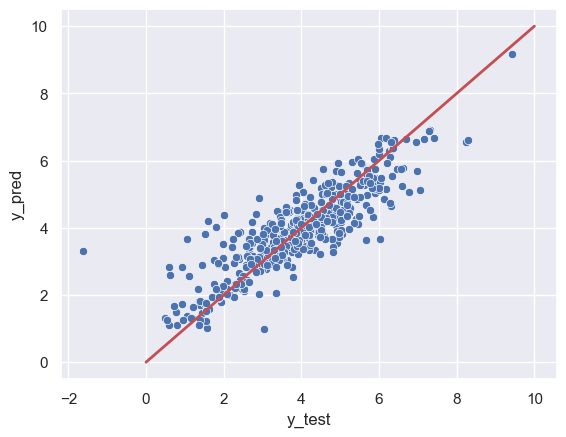

In [91]:
sns.scatterplot(y_test, y_pred).set(xlabel="y_test", ylabel="y_pred")
plt.plot([0.0, 10.0], [0.0, 10.0], "r-", lw=2)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


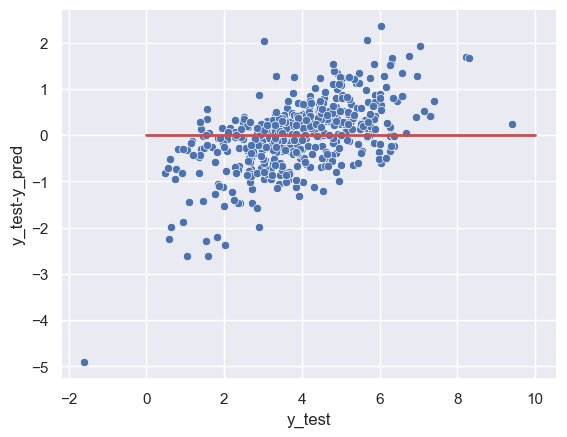

In [92]:
sns.scatterplot(y_test, y_test - y_pred).set(xlabel="y_test", ylabel="y_test-y_pred")
plt.plot([0.0, 10.0], [0.0, 0.0], "r-", lw=2)

Comme pour la prédictio de la conso, sur les valeurs plus petites et les plus grandes de y_test, la prédiction est moins bonne. 

Distribution des écarts entre y_test et y_pred:

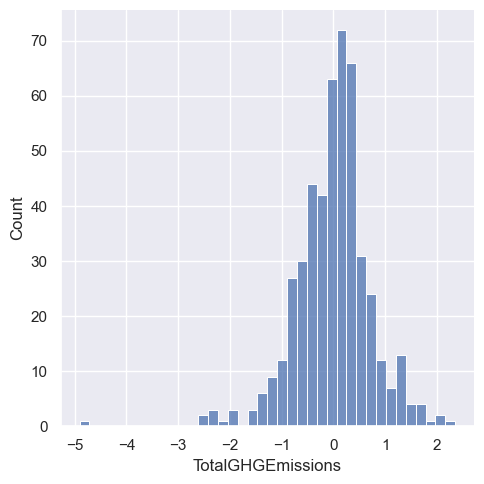

In [93]:
sns.displot(y_test - y_pred)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


[Text(0.5, 0, 'y_test'), Text(0, 0.5, 'y_test/y_pred')]

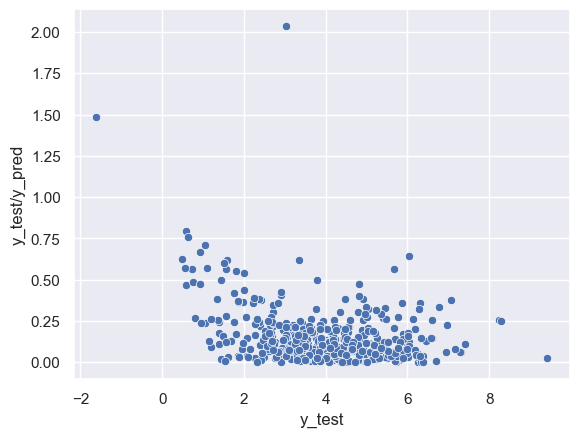

In [94]:
sns.scatterplot(y_test, abs(1 - (y_test / y_pred))).set(
    xlabel="y_test", ylabel="y_test/y_pred"
)

## 3.9. Feature importance

A ce stade l'idée est de detecter les features qui ont le plus d'importance dans les prédicitons. 

Eventuellement retirer quelques features qui ont peu d'importance


SHAP KO avec estimateur SVR. Je considère donc pour l'analyse de la Feature Important un modèle linéaire de sklearn: RIDGE
R² =0.65 (au lieu de 0.69 pour SVR)

### 3.9.1 Reconstruction du dataset pour utilisation dans SHAP:

l'idée est de récuperer:
- le X_train transformé avec le nom des colonnes,
- ainsi que le'estimateur utilisé (et non l'ensemble du modèle) 

*note: quand je passe dans SHAP, mon best_estimator_, il y a un erreur car mon best estimator est un gridsearchCV, lui même contenant un pipeline.*

#### 3.9.1.1 Récupération d'un modèle linéaire => Ridge()


In [95]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'has_parking',
                                                   'PropertyGFABuilding(s)',
                                                   'Steam_use',
                                                   'Electricity_use', 'Gas_use',
                                                   'ENERGYSTARScore'])])),
                ('imputer', KNNImput

In [96]:
# Récupération du param_grid ayant servi pour Ridge (car SHAP KO avec SVR)
param_grid = {
    "scaler": [MinMaxScaler(), RobustScaler(), StandardScaler(), "passthrough"],
    "estimator": [
        Ridge(),
    ],
    "estimator__alpha": [5, 100, 200, 500],
}

In [97]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)
grid.fit(X_log, y_log)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('OneHot',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['PrimaryPropertyType']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'YearBuilt',
                                                                          'NumberofBuildings',
                                                                          'NumberofFloors',
                         

In [98]:
model2 = grid.best_estimator_
model2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'has_parking',
                                                   'PropertyGFABuilding(s)',
                                                   'Steam_use',
                                                   'Electricity_use', 'Gas_use',
                                                   'ENERGYSTARScore'])])),
                ('imputer', KNNImput

In [99]:
model2.score(X_test, y_test)

0.7330084526347032

In [100]:
model2.score(X_train, y_train)

0.7415249119194482

####  3.9.1.2 Décomposition du modèle:

In [101]:
PREP = model2["preprocessor"]
PREP

ColumnTransformer(transformers=[('OneHot', OneHotEncoder(sparse=False),
                                 ['PrimaryPropertyType']),
                                ('num', 'passthrough',
                                 ['Latitude', 'Longitude', 'YearBuilt',
                                  'NumberofBuildings', 'NumberofFloors',
                                  'has_parking', 'PropertyGFABuilding(s)',
                                  'Steam_use', 'Electricity_use', 'Gas_use',
                                  'ENERGYSTARScore'])])

In [102]:
IMP = model2["imputer"]

In [103]:
SCA = model2["scaler"]
SCA

'passthrough'

In [104]:
EST = model2["estimator"]
EST

Ridge(alpha=5)

Récupération du nom des colonnes (après OneHotEncoder) 

In [105]:
feat = PREP.get_feature_names_out()
feat

array(['OneHot__PrimaryPropertyType_Distribution Center',
       'OneHot__PrimaryPropertyType_Entertainment',
       'OneHot__PrimaryPropertyType_Hospital',
       'OneHot__PrimaryPropertyType_Hotel',
       'OneHot__PrimaryPropertyType_K-12 School',
       'OneHot__PrimaryPropertyType_Laboratory',
       'OneHot__PrimaryPropertyType_Large Office',
       'OneHot__PrimaryPropertyType_Medical Office',
       'OneHot__PrimaryPropertyType_Office',
       'OneHot__PrimaryPropertyType_Other',
       'OneHot__PrimaryPropertyType_Parking',
       'OneHot__PrimaryPropertyType_Refrigerated Warehouse',
       'OneHot__PrimaryPropertyType_Residence Hall',
       'OneHot__PrimaryPropertyType_Restaurant',
       'OneHot__PrimaryPropertyType_Retail Store',
       'OneHot__PrimaryPropertyType_Self-Storage Facility',
       'OneHot__PrimaryPropertyType_Senior Care Community',
       'OneHot__PrimaryPropertyType_Small- and Mid-Sized Office',
       'OneHot__PrimaryPropertyType_Supermarket / Grocery Sto

####  3.9.1.3 Reconstruction du dataframe qui sera utilisé par SHAP 

In [106]:
A = PREP.transform(X_train)
A = IMP.transform(A)
# A=SCA.transform(A)
A = pd.DataFrame(A, columns=feat)
A.shape

(1126, 33)

####  3.9.1.4 Summary plot SHAP 

In [107]:
explainer = shap.LinearExplainer(EST, A)
explainer

In [108]:
shap_values = explainer(A)

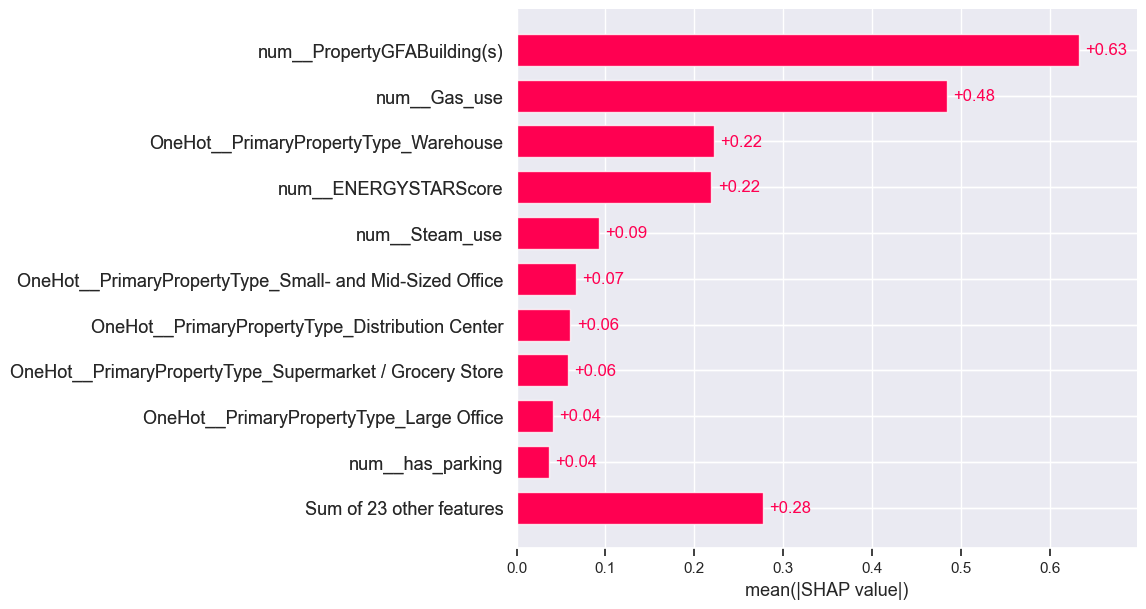

In [109]:
shap.plots.bar(shap_values, max_display=11)

Concernant la prédicition des gaz à effet de serre, l'importance des variables différe par rapport à la prédiction de l'énergie. Ici l'utilisation du gaz est prépondérante (après superficie mais avant ENERGYSTARScore)
On constate que les coordonnées géo n'ont que très peu d'importance dans la prédiciton. Je supprime les coordonnées dans la prochaine itération.

# 4. Amélioration avec Feature Engineering plus poussé et impact ENERGYSTARScore

## 4.1 Utlisation des features parking et type d'energie en %age (plutot qu'en booléen)

### Sur base df3, passage au log des features concernées

In [110]:
df3_log = df3.copy()

In [111]:
df3_log.columns

Index(['PrimaryPropertyType', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)',
       'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore',
       'superfice/etage', 'superfice/batiment', 'Parking_pct', 'pct_gaz',
       'pct_elec', 'pct_steam'],
      dtype='object')

In [112]:
col_log = [
    "SiteEnergyUseWN(kBtu)",
    "TotalGHGEmissions",
    "NumberofBuildings",
    "NumberofFloors",
    "PropertyGFABuilding(s)",
    "superfice/etage",
    "superfice/batiment",
]

In [113]:
for col in col_log:
    df3_log[col] = np.log1p(df3[col])
df3_log

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),SiteEnergyUseWN(kBtu),TotalGHGEmissions,ENERGYSTARScore,superfice/etage,superfice/batiment,Parking_pct,pct_gaz,pct_elec,pct_steam
0,Hotel,47.61220,-122.33799,1927,0.693147,2.564949,11.390023,15.824652,5.525373,60.0,8.905241,11.390023,0.000000,0.2,0.5,0.3
1,Hotel,47.61317,-122.33393,1996,0.693147,2.484907,11.390792,15.974742,5.693261,61.0,8.993009,11.390792,0.145453,0.6,0.4,0.0
2,Hotel,47.61393,-122.33810,1969,0.693147,3.737670,13.540275,18.118725,7.645053,43.0,9.826755,13.540275,0.205748,0.0,0.7,0.3
3,Hotel,47.61412,-122.33664,1926,0.693147,2.397895,11.023878,15.753792,5.660979,56.0,8.721439,11.023878,0.000000,0.3,0.4,0.3
4,Hotel,47.61375,-122.34047,1980,0.693147,2.944439,11.640272,16.500395,6.226556,75.0,8.750049,11.640272,0.353115,0.6,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,47.62497,-122.33883,2015,0.693147,1.945910,12.469448,17.530998,6.908815,NaN,10.677708,12.469448,0.246251,0.4,0.6,0.0
1605,University,47.66127,-122.31256,1962,0.693147,0.693147,11.128336,14.972650,3.142858,NaN,11.128336,11.128336,0.000000,0.0,1.0,0.0
1606,Entertainment,47.70541,-122.32232,2005,0.693147,0.693147,9.933871,13.364472,1.693779,NaN,9.933871,9.933871,0.000000,0.0,1.0,0.0
1607,Entertainment,47.63228,-122.31574,1912,0.693147,0.693147,10.062455,15.720053,5.561527,NaN,10.062455,10.062455,0.000000,0.8,0.2,0.0


### Adaptation de X_log

In [114]:
X_log = df3_log.drop(
    ["SiteEnergyUseWN(kBtu)", "TotalGHGEmissions", "Latitude", "Longitude"], axis=1
)
X_log

,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,superfice/etage,superfice/batiment,Parking_pct,pct_gaz,pct_elec,pct_steam
0,Hotel,1927,0.693147,2.564949,11.390023,60.0,8.905241,11.390023,0.000000,0.2,0.5,0.3
1,Hotel,1996,0.693147,2.484907,11.390792,61.0,8.993009,11.390792,0.145453,0.6,0.4,0.0
2,Hotel,1969,0.693147,3.737670,13.540275,43.0,9.826755,13.540275,0.205748,0.0,0.7,0.3
3,Hotel,1926,0.693147,2.397895,11.023878,56.0,8.721439,11.023878,0.000000,0.3,0.4,0.3
4,Hotel,1980,0.693147,2.944439,11.640272,75.0,8.750049,11.640272,0.353115,0.6,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,2015,0.693147,1.945910,12.469448,NaN,10.677708,12.469448,0.246251,0.4,0.6,0.0
1605,University,1962,0.693147,0.693147,11.128336,NaN,11.128336,11.128336,0.000000,0.0,1.0,0.0
1606,Entertainment,2005,0.693147,0.693147,9.933871,NaN,9.933871,9.933871,0.000000,0.0,1.0,0.0
1607,Entertainment,1912,0.693147,0.693147,10.062455,NaN,10.062455,10.062455,0.000000,0.8,0.2,0.0


### Adaptation du pipeline

In [115]:
num_feat = X_log.select_dtypes(include=np.number).columns.to_list()
num_feat

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'ENERGYSTARScore',
 'superfice/etage',
 'superfice/batiment',
 'Parking_pct',
 'pct_gaz',
 'pct_elec',
 'pct_steam']

In [116]:
cat_feat = X_log.select_dtypes(exclude=np.number).columns.to_list()
cat_feat

['PrimaryPropertyType']

In [117]:
transformer = ColumnTransformer(
    transformers=[
        ("OneHot", OneHotEncoder(sparse=False), cat_feat),
        ("num", "passthrough", num_feat),
    ]
)

In [118]:
pipeline = Pipeline(
    [
        ("preprocessor", transformer),
        ("imputer", KNNImputer()),
        ("scaler", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore',
                                                   'superfice/etage',
                                                   'superfice/batiment',
                                                   'Parking_pct', 'pct_gaz',
                                                   'pct_elec',
                                             

In [119]:
param_grid = {
    "scaler": [
        MinMaxScaler(),
        Normalizer(),
        RobustScaler(),
        StandardScaler(),
        "passthrough",
    ],
    "estimator": [
        LinearRegression(),
        SGDRegressor(),
        Ridge(),
        Lasso(),
        RandomForestRegressor(),
        KNeighborsRegressor(),
        SVR(),
    ],
}

In [120]:
param_grid

{'scaler': [MinMaxScaler(),
  Normalizer(),
  RobustScaler(),
  StandardScaler(),
  'passthrough'],
 'estimator': [LinearRegression(),
  SGDRegressor(),
  Ridge(),
  Lasso(),
  RandomForestRegressor(),
  KNeighborsRegressor(),
  SVR()]}

In [121]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)
grid.fit(X_log, y_log)
res = result(grid, log_target=1, transf_feat=1, features="log + OneHot + NRJ_pct")
res

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
30,0.41,0.01,0.07,0.00,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",8.000000e-01,4.000000e-02,1,8.600000e-01,1.000000e-02,-4.000000e-01,4.000000e-02,1,-3.500000e-01,0.000000e+00,-3.400000e-01,7.000000e-02,1,-2.800000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
10,0.15,0.02,0.03,0.01,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",7.800000e-01,3.000000e-02,2,8.400000e-01,1.000000e-02,-4.200000e-01,3.000000e-02,3,-4.100000e-01,0.000000e+00,-3.600000e-01,7.000000e-02,2,-3.400000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
14,0.15,0.01,0.03,0.01,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",7.800000e-01,3.000000e-02,3,8.400000e-01,1.000000e-02,-4.200000e-01,3.000000e-02,4,-4.100000e-01,0.000000e+00,-3.600000e-01,7.000000e-02,3,-3.400000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
12,0.17,0.01,0.03,0.01,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",7.800000e-01,3.000000e-02,4,8.400000e-01,1.000000e-02,-4.200000e-01,3.000000e-02,7,-4.100000e-01,0.000000e+00,-3.600000e-01,7.000000e-02,4,-3.400000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
13,0.15,0.02,0.03,0.01,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",7.800000e-01,3.000000e-02,5,8.400000e-01,1.000000e-02,-4.200000e-01,3.000000e-02,6,-4.100000e-01,0.000000e+00,-3.600000e-01,7.000000e-02,5,-3.400000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
0,0.15,0.02,0.03,0.01,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",7.800000e-01,3.000000e-02,6,8.400000e-01,1.000000e-02,-4.200000e-01,3.000000e-02,8,-4.100000e-01,0.000000e+00,-3.600000e-01,7.000000e-02,6,-3.400000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
2,0.16,0.01,0.03,0.01,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",7.800000e-01,3.000000e-02,7,8.400000e-01,1.000000e-02,-4.200000e-01,3.000000e-02,9,-4.100000e-01,0.000000e+00,-3.600000e-01,7.000000e-02,7,-3.400000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
4,0.15,0.02,0.03,0.01,LinearRegression(),passthrough,"{'estimator': LinearRegression(), 'scaler': 'p...",7.800000e-01,3.000000e-02,8,8.400000e-01,1.000000e-02,-4.200000e-01,3.000000e-02,10,-4.100000e-01,0.000000e+00,-3.600000e-01,7.000000e-02,8,-3.400000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
1,0.18,0.04,0.03,0.01,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",7.800000e-01,3.000000e-02,9,8.400000e-01,1.000000e-02,-4.200000e-01,3.000000e-02,5,-4.100000e-01,0.000000e+00,-3.600000e-01,7.000000e-02,10,-3.400000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
3,0.16,0.02,0.03,0.01,LinearRegression(),StandardScaler(),"{'estimator': LinearRegression(), 'scaler': St...",7.800000e-01,3.000000e-02,10,8.400000e-01,1.000000e-02,-4.200000e-01,3.000000e-02,12,-4.100000e-01,0.000000e+00,-3.600000e-01,7.000000e-02,9,-3.400000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct


Pour SVR, R² passe de 0.69 à 0.80
En revanche r² pour le Ridge passe de 0.65 à 0.78) avec un fit time bien infériuer à celui du SVR (0.15s contre 0.41s)

#### SVR

In [122]:
param_grid = {
    "scaler": [
        MinMaxScaler(),
    ],
    "estimator": [
        SVR(),
    ],
    "estimator__epsilon": [0, 0.01, 0.05, 0.2],
    "estimator__C": [1, 2, 3, 5],
}

In [123]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)
grid.fit(X_log, y_log)
res = result(grid, log_target=1, transf_feat=1, features="log + OneHot + NRJ_pct")
res

Fitting 10 folds for each of 16 candidates, totalling 160 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__C,param_estimator__epsilon,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
6,0.51,0.04,0.09,0.01,"SVR(C=2, epsilon=0.05)",2,0.05,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.05), 'estimat...",0.8,0.04,1,0.87,0.01,-0.4,0.04,1,-0.33,0.0,-0.33,0.08,1,-0.27,0.01,1,1,log + OneHot + NRJ_pct
5,0.52,0.03,0.10,0.01,"SVR(C=2, epsilon=0.05)",2,0.01,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.05), 'estimat...",0.8,0.04,2,0.87,0.01,-0.4,0.04,5,-0.33,0.0,-0.33,0.07,2,-0.27,0.01,1,1,log + OneHot + NRJ_pct
8,0.56,0.06,0.10,0.01,"SVR(C=2, epsilon=0.05)",3,0,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.05), 'estimat...",0.8,0.04,3,0.88,0.01,-0.4,0.04,11,-0.32,0.0,-0.33,0.07,3,-0.26,0.01,1,1,log + OneHot + NRJ_pct
4,0.52,0.03,0.09,0.01,"SVR(C=2, epsilon=0.05)",2,0,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.05), 'estimat...",0.8,0.04,4,0.87,0.01,-0.4,0.04,6,-0.33,0.0,-0.33,0.07,4,-0.27,0.01,1,1,log + OneHot + NRJ_pct
10,0.53,0.03,0.10,0.02,"SVR(C=2, epsilon=0.05)",3,0.05,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.05), 'estimat...",0.8,0.04,5,0.88,0.01,-0.4,0.04,3,-0.32,0.0,-0.33,0.08,6,-0.26,0.01,1,1,log + OneHot + NRJ_pct
9,0.56,0.04,0.09,0.01,"SVR(C=2, epsilon=0.05)",3,0.01,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.05), 'estimat...",0.8,0.04,6,0.88,0.01,-0.4,0.04,10,-0.32,0.0,-0.33,0.07,5,-0.26,0.01,1,1,log + OneHot + NRJ_pct
3,0.36,0.02,0.06,0.01,"SVR(C=2, epsilon=0.05)",1,0.2,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.05), 'estimat...",0.8,0.04,7,0.86,0.01,-0.4,0.04,7,-0.36,0.0,-0.34,0.07,7,-0.28,0.01,1,1,log + OneHot + NRJ_pct
7,0.42,0.03,0.07,0.01,"SVR(C=2, epsilon=0.05)",2,0.2,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.05), 'estimat...",0.8,0.04,8,0.87,0.01,-0.4,0.04,4,-0.34,0.0,-0.34,0.07,8,-0.27,0.01,1,1,log + OneHot + NRJ_pct
11,0.40,0.03,0.06,0.01,"SVR(C=2, epsilon=0.05)",3,0.2,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.05), 'estimat...",0.8,0.04,9,0.88,0.01,-0.4,0.04,8,-0.34,0.0,-0.34,0.08,10,-0.26,0.01,1,1,log + OneHot + NRJ_pct
14,0.49,0.03,0.08,0.00,"SVR(C=2, epsilon=0.05)",5,0.05,MinMaxScaler(),"{'estimator': SVR(C=2, epsilon=0.05), 'estimat...",0.8,0.04,10,0.88,0.01,-0.4,0.04,9,-0.31,0.0,-0.34,0.07,9,-0.24,0.01,1,1,log + OneHot + NRJ_pct


Pas d'amélioration

In [124]:
# model=grid.best_estimator_
# model

#### SGD Regressor

In [125]:
param_grid = {
    "scaler": [MinMaxScaler(), RobustScaler(), StandardScaler(), "passthrough"],
    "estimator": [
        SGDRegressor(),
    ],
    "estimator__eta0": np.linspace(0.01, 0.5, 11),
}

In [126]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)
grid.fit(X_log, y_log)
res = result(grid, log_target=1, transf_feat=1, features="log + OneHot + NRJ_pct")
res

Fitting 10 folds for each of 44 candidates, totalling 440 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__eta0,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
2,0.17,0.02,0.03,0.01,SGDRegressor(),0.01,StandardScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",7.800000e-01,3.000000e-02,1,8.400000e-01,1.000000e-02,-4.200000e-01,3.000000e-02,2,-4.100000e-01,0.000000e+00,-3.600000e-01,7.000000e-02,1,-3.400000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
4,0.17,0.02,0.03,0.01,SGDRegressor(),0.059,MinMaxScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",7.800000e-01,3.000000e-02,2,8.400000e-01,1.000000e-02,-4.200000e-01,3.000000e-02,3,-4.100000e-01,0.000000e+00,-3.600000e-01,7.000000e-02,2,-3.400000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
12,0.15,0.01,0.03,0.01,SGDRegressor(),0.157,MinMaxScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",7.800000e-01,3.000000e-02,3,8.300000e-01,1.000000e-02,-4.300000e-01,3.000000e-02,4,-4.200000e-01,1.000000e-02,-3.600000e-01,6.000000e-02,3,-3.500000e-01,2.000000e-02,1,1,log + OneHot + NRJ_pct
8,0.16,0.01,0.03,0.01,SGDRegressor(),0.108,MinMaxScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",7.800000e-01,3.000000e-02,4,8.400000e-01,1.000000e-02,-4.200000e-01,3.000000e-02,1,-4.100000e-01,0.000000e+00,-3.700000e-01,6.000000e-02,4,-3.400000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
5,0.17,0.01,0.03,0.01,SGDRegressor(),0.059,RobustScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",7.800000e-01,3.000000e-02,5,8.300000e-01,1.000000e-02,-4.300000e-01,3.000000e-02,5,-4.200000e-01,0.000000e+00,-3.700000e-01,7.000000e-02,6,-3.500000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
32,0.15,0.01,0.03,0.01,SGDRegressor(),0.402,MinMaxScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",7.800000e-01,4.000000e-02,6,8.300000e-01,1.000000e-02,-4.300000e-01,4.000000e-02,6,-4.200000e-01,1.000000e-02,-3.700000e-01,7.000000e-02,5,-3.500000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
24,0.14,0.01,0.03,0.01,SGDRegressor(),0.304,MinMaxScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",7.800000e-01,3.000000e-02,7,8.300000e-01,1.000000e-02,-4.300000e-01,3.000000e-02,7,-4.200000e-01,1.000000e-02,-3.700000e-01,6.000000e-02,7,-3.500000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
21,0.16,0.01,0.03,0.01,SGDRegressor(),0.255,RobustScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",7.800000e-01,3.000000e-02,8,8.300000e-01,1.000000e-02,-4.300000e-01,3.000000e-02,13,-4.300000e-01,2.000000e-02,-3.700000e-01,7.000000e-02,12,-3.600000e-01,2.000000e-02,1,1,log + OneHot + NRJ_pct
9,0.16,0.01,0.03,0.00,SGDRegressor(),0.108,RobustScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",7.800000e-01,3.000000e-02,9,8.300000e-01,1.000000e-02,-4.300000e-01,3.000000e-02,12,-4.200000e-01,1.000000e-02,-3.700000e-01,7.000000e-02,9,-3.500000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct
20,0.16,0.02,0.03,0.00,SGDRegressor(),0.255,MinMaxScaler(),"{'estimator': SGDRegressor(), 'estimator__eta0...",7.800000e-01,3.000000e-02,10,8.300000e-01,1.000000e-02,-4.300000e-01,4.000000e-02,8,-4.200000e-01,1.000000e-02,-3.700000e-01,7.000000e-02,11,-3.500000e-01,1.000000e-02,1,1,log + OneHot + NRJ_pct


Pas d'amélioration

#### Ridge

In [127]:
param_grid = {
    "scaler": [MinMaxScaler(), RobustScaler(), StandardScaler(), "passthrough"],
    "estimator": [
        Ridge(),
    ],
    "estimator__alpha": [2, 4, 5, 100, 200, 500],
}

In [128]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)
grid.fit(X_log, y_log)
res = result(grid, log_target=1, transf_feat=1, features="log + OneHot + NRJ_pct")
res

Fitting 10 folds for each of 24 candidates, totalling 240 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__alpha,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
10,0.14,0.01,0.03,0.01,Ridge(alpha=5),5,StandardScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.78,0.03,1,0.84,0.01,-0.42,0.03,1,-0.41,0.00,-0.36,0.07,1,-0.34,0.01,1,1,log + OneHot + NRJ_pct
6,0.15,0.01,0.03,0.00,Ridge(alpha=5),4,StandardScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.78,0.03,2,0.84,0.01,-0.42,0.03,2,-0.41,0.00,-0.36,0.07,2,-0.34,0.01,1,1,log + OneHot + NRJ_pct
2,0.17,0.02,0.03,0.01,Ridge(alpha=5),2,StandardScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.78,0.03,3,0.84,0.01,-0.42,0.03,3,-0.41,0.00,-0.36,0.07,3,-0.34,0.01,1,1,log + OneHot + NRJ_pct
1,0.17,0.02,0.03,0.01,Ridge(alpha=5),2,RobustScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.78,0.03,4,0.84,0.01,-0.42,0.03,5,-0.41,0.00,-0.36,0.07,4,-0.34,0.01,1,1,log + OneHot + NRJ_pct
3,0.14,0.01,0.03,0.01,Ridge(alpha=5),2,passthrough,"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.78,0.03,5,0.84,0.01,-0.42,0.03,4,-0.41,0.00,-0.36,0.07,5,-0.34,0.01,1,1,log + OneHot + NRJ_pct
0,0.15,0.02,0.03,0.01,Ridge(alpha=5),2,MinMaxScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.78,0.03,6,0.84,0.01,-0.42,0.03,6,-0.41,0.00,-0.36,0.07,6,-0.34,0.01,1,1,log + OneHot + NRJ_pct
5,0.17,0.01,0.03,0.00,Ridge(alpha=5),4,RobustScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.78,0.03,7,0.84,0.01,-0.42,0.03,7,-0.41,0.00,-0.36,0.07,7,-0.34,0.01,1,1,log + OneHot + NRJ_pct
14,0.15,0.01,0.03,0.01,Ridge(alpha=5),100,StandardScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.78,0.03,8,0.84,0.01,-0.42,0.03,9,-0.41,0.00,-0.36,0.07,8,-0.34,0.01,1,1,log + OneHot + NRJ_pct
9,0.17,0.02,0.03,0.01,Ridge(alpha=5),5,RobustScaler(),"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.78,0.03,9,0.83,0.01,-0.42,0.03,8,-0.41,0.00,-0.37,0.07,9,-0.35,0.01,1,1,log + OneHot + NRJ_pct
7,0.15,0.01,0.03,0.01,Ridge(alpha=5),4,passthrough,"{'estimator': Ridge(alpha=5), 'estimator__alph...",0.78,0.03,10,0.83,0.01,-0.42,0.03,10,-0.41,0.00,-0.37,0.07,10,-0.35,0.01,1,1,log + OneHot + NRJ_pct


Modèle retenu. r² inférieur à SVR mais fit time beaucoup plus rapide

In [129]:
model = grid.best_estimator_
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore',
                                                   'superfice/etage',
                                                   'superfice/batiment',
                                                   'Parking_pct', 'pct_gaz',
                                                   'pct_elec',
                                             

### Courbe d'apprentissage

In [130]:
from sklearn.model_selection import learning_curve

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_transform(
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", li

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_transform(
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", li

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_transform(
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", li

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_transform(
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", li

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_transform(
  File "C:\Users\xavie\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", li

Text(0.5, 1.0, "Courbe d'apprentissage / Emissions GHG")

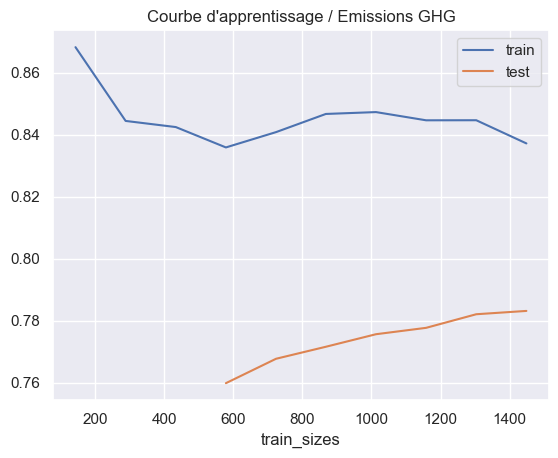

In [131]:
N, train_score, test_score = learning_curve(
    model, X_log, y_log, train_sizes=np.linspace(0.1, 1, 10), cv=10
)
plt.plot(N, train_score.mean(axis=1), label="train")
plt.plot(N, test_score.mean(axis=1), label="test")
plt.xlabel("train_sizes")
plt.legend()
plt.title("Courbe d'apprentissage / Emissions GHG")

### Représentation graphique des performance (y_pred vs y_test)

Notre meilleur estimateur est donc encore une fois le SVR

Entrainement du meilleur modèle via Train/Test Split

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.3)
print("Train set:", X_train.shape)
print("Test set:", X_test.shape)
print("Train target:", y_train.shape)
print("Test target:", y_test.shape)

Train set: (1126, 12)
Test set: (483, 12)
Train target: (1126,)
Test target: (483,)


In [133]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore',
                                                   'superfice/etage',
                                                   'superfice/batiment',
                                                   'Parking_pct', 'pct_gaz',
                                                   'pct_elec',
                                             

In [134]:
model.score(X_train, y_train)

0.8517667128870484

In [135]:
model.score(X_test, y_test)

0.8063355346715161

In [136]:
y_pred = model.predict(X_test)

Représentation graphique

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


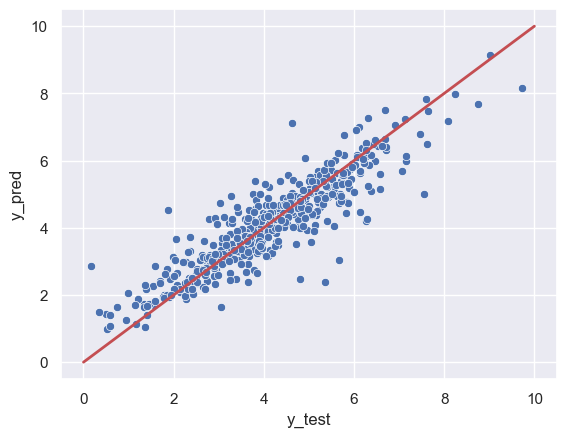

In [137]:
sns.scatterplot(y_test, y_pred).set(xlabel="y_test", ylabel="y_pred")
plt.plot([0.0, 10.0], [0.0, 10.0], "r-", lw=2)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


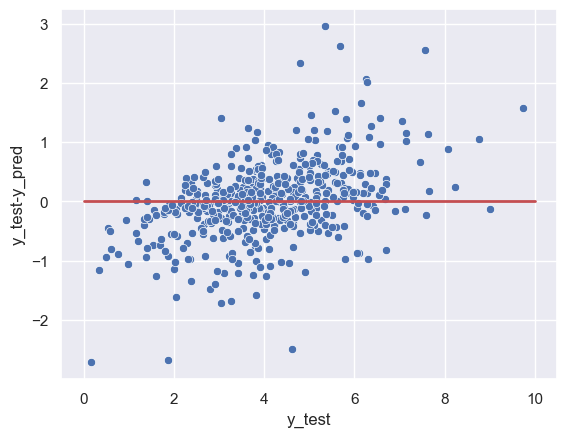

In [138]:
sns.scatterplot(y_test, y_test - y_pred).set(xlabel="y_test", ylabel="y_test-y_pred")
plt.plot([0.0, 10.0], [0.0, 0.0], "r-", lw=2)

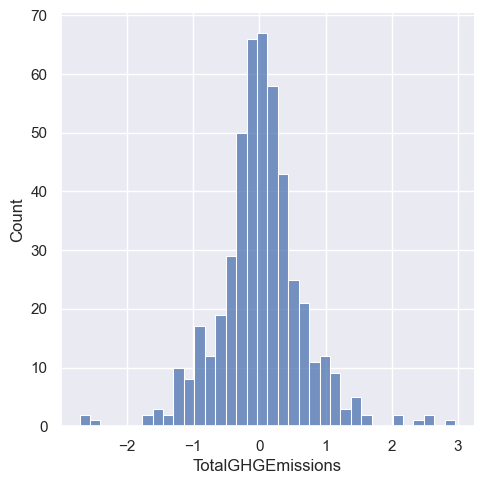

In [139]:
sns.displot(y_test - y_pred)

Dans cette version du modèle, on constate encore une fois que les predictions sont moins fiables sur les valeurs extremes

## 4.2 Feature importance

Même constat que precedemment, la SVR notre meilleur modèle n'est pas comptabile avec SHAP. Je prends donc le 2eme meilleur estimateur => Ridge

### 4.2.1 Reconstruction du dataset pour utilisation dans SHAP:

l'idée est de récuperer:
- le X_train transformé avec le nom des colonnes,
- ainsi que le'estimateur utilisé (et non l'ensemble du modèle) 

*note: quand je passe dans SHAP, mon best_estimator_, il y a un erreur car mon best estimator est un gridsearchCV, lui même contenant un pipeline.*

#### 4.2.1.1 Récupération du meilleur modèle => Ridge() avec Standard Scaler (R²=0.78)
=> Model


In [140]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore',
                                                   'superfice/etage',
                                                   'superfice/batiment',
                                                   'Parking_pct', 'pct_gaz',
                                                   'pct_elec',
                                             

In [141]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore',
                                                   'superfice/etage',
                                                   'superfice/batiment',
                                                   'Parking_pct', 'pct_gaz',
                                                   'pct_elec',
                                             

In [142]:
model.score(X_test, y_test)

0.8063355346715161

In [143]:
model.score(X_train, y_train)

0.8517667128870484

Décomposition du modèle:

In [144]:
PREP = model["preprocessor"]
PREP

ColumnTransformer(transformers=[('OneHot', OneHotEncoder(sparse=False),
                                 ['PrimaryPropertyType']),
                                ('num', 'passthrough',
                                 ['YearBuilt', 'NumberofBuildings',
                                  'NumberofFloors', 'PropertyGFABuilding(s)',
                                  'ENERGYSTARScore', 'superfice/etage',
                                  'superfice/batiment', 'Parking_pct',
                                  'pct_gaz', 'pct_elec', 'pct_steam'])])

In [145]:
IMP = model["imputer"]

In [146]:
SCA = model["scaler"]
SCA

StandardScaler()

In [147]:
EST = model["estimator"]
EST

Ridge(alpha=5)

Récupération du nom des colonnes (après OneHotEncoder) 

In [148]:
feat = PREP.get_feature_names_out()
feat

array(['OneHot__PrimaryPropertyType_Distribution Center',
       'OneHot__PrimaryPropertyType_Entertainment',
       'OneHot__PrimaryPropertyType_Hospital',
       'OneHot__PrimaryPropertyType_Hotel',
       'OneHot__PrimaryPropertyType_K-12 School',
       'OneHot__PrimaryPropertyType_Laboratory',
       'OneHot__PrimaryPropertyType_Large Office',
       'OneHot__PrimaryPropertyType_Medical Office',
       'OneHot__PrimaryPropertyType_Office',
       'OneHot__PrimaryPropertyType_Other',
       'OneHot__PrimaryPropertyType_Parking',
       'OneHot__PrimaryPropertyType_Refrigerated Warehouse',
       'OneHot__PrimaryPropertyType_Residence Hall',
       'OneHot__PrimaryPropertyType_Restaurant',
       'OneHot__PrimaryPropertyType_Retail Store',
       'OneHot__PrimaryPropertyType_Self-Storage Facility',
       'OneHot__PrimaryPropertyType_Senior Care Community',
       'OneHot__PrimaryPropertyType_Small- and Mid-Sized Office',
       'OneHot__PrimaryPropertyType_Supermarket / Grocery Sto

#### 4.2.1.2 Reconstruction du dataframe qui sera utilisé par SHAP 

In [149]:
A = PREP.transform(X_train)
A = IMP.transform(A)
A = SCA.transform(A)
A = pd.DataFrame(A, columns=feat)
A.shape

(1126, 33)

#### 4.2.1.3 Summary plot SHAP

In [150]:
explainer = shap.LinearExplainer(EST, A)
explainer

In [151]:
shap_values = explainer(A)

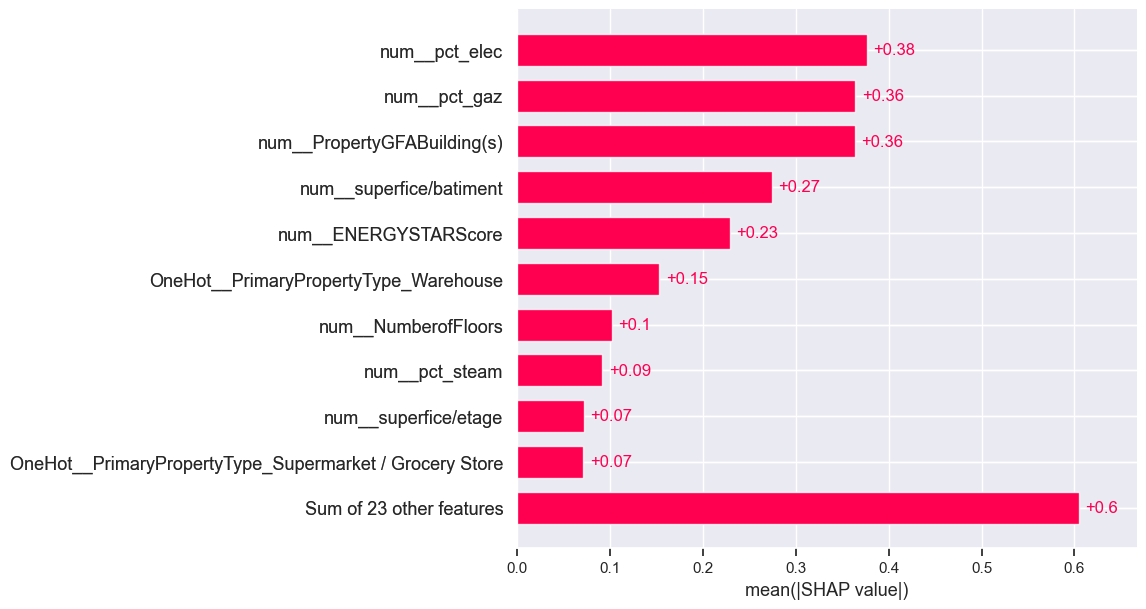

In [152]:
shap.plots.bar(shap_values, max_display=11)

On prenant en compte le %age du type d'energie consommée, le gaz arrive largement en tête de la Feature Importance.
Suivie de la superficie du batiment et de l'ENERGYSTARScore.

Vérifion à l'aide d'un GridSearchCV le delta dans les résultats du modèle avec et sans ENERGYSTARScore

## 4.3 Impact de l'energy score

Adaptation du dataset X_log

In [153]:
X_log = X_log.drop(["ENERGYSTARScore"], axis=1)
X_log

,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),superfice/etage,superfice/batiment,Parking_pct,pct_gaz,pct_elec,pct_steam
0,Hotel,1927,0.693147,2.564949,11.390023,8.905241,11.390023,0.000000,0.2,0.5,0.3
1,Hotel,1996,0.693147,2.484907,11.390792,8.993009,11.390792,0.145453,0.6,0.4,0.0
2,Hotel,1969,0.693147,3.737670,13.540275,9.826755,13.540275,0.205748,0.0,0.7,0.3
3,Hotel,1926,0.693147,2.397895,11.023878,8.721439,11.023878,0.000000,0.3,0.4,0.3
4,Hotel,1980,0.693147,2.944439,11.640272,8.750049,11.640272,0.353115,0.6,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1604,Laboratory,2015,0.693147,1.945910,12.469448,10.677708,12.469448,0.246251,0.4,0.6,0.0
1605,University,1962,0.693147,0.693147,11.128336,11.128336,11.128336,0.000000,0.0,1.0,0.0
1606,Entertainment,2005,0.693147,0.693147,9.933871,9.933871,9.933871,0.000000,0.0,1.0,0.0
1607,Entertainment,1912,0.693147,0.693147,10.062455,10.062455,10.062455,0.000000,0.8,0.2,0.0


Adaptation du pipeline

In [154]:
num_feat = X_log.select_dtypes(include=np.number).columns.to_list()
num_feat

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'superfice/etage',
 'superfice/batiment',
 'Parking_pct',
 'pct_gaz',
 'pct_elec',
 'pct_steam']

In [155]:
transformer = ColumnTransformer(
    transformers=[
        ("OneHot", OneHotEncoder(sparse=False), cat_feat),
        ("num", "passthrough", num_feat),
    ]
)
transformer

ColumnTransformer(transformers=[('OneHot', OneHotEncoder(sparse=False),
                                 ['PrimaryPropertyType']),
                                ('num', 'passthrough',
                                 ['YearBuilt', 'NumberofBuildings',
                                  'NumberofFloors', 'PropertyGFABuilding(s)',
                                  'superfice/etage', 'superfice/batiment',
                                  'Parking_pct', 'pct_gaz', 'pct_elec',
                                  'pct_steam'])])

In [156]:
pipeline = Pipeline(
    [
        ("preprocessor", transformer),
        ("imputer", KNNImputer()),
        ("scaler", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('OneHot',
                                                  OneHotEncoder(sparse=False),
                                                  ['PrimaryPropertyType']),
                                                 ('num', 'passthrough',
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)',
                                                   'superfice/etage',
                                                   'superfice/batiment',
                                                   'Parking_pct', 'pct_gaz',
                                                   'pct_elec',
                                                   'pct_steam'])])),
                ('imputer', KNNImputer()), ('s

In [157]:
param_grid = {
    "scaler": [
        MinMaxScaler(),
        Normalizer(),
        RobustScaler(),
        StandardScaler(),
        "passthrough",
    ],
    "estimator": [
        LinearRegression(),
        SGDRegressor(),
        Ridge(),
        Lasso(),
        RandomForestRegressor(),
        KNeighborsRegressor(),
        SVR(),
    ],
}

In [158]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=("r2", "neg_mean_absolute_error", "neg_mean_squared_error"),
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit="r2",
)
grid.fit(X_log, y_log)
res = result(
    grid, log_target=1, transf_feat=1, features="log + OneHot + NRJ_pct - NRJScore"
)
res.head(10)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features
30,0.26,0.01,0.06,0.00,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.75,0.04,1,0.83,0.01,-0.46,0.03,1,-0.41,0.0,-0.41,0.07,1,-0.35,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
8,0.02,0.01,0.01,0.00,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",0.74,0.04,2,0.80,0.01,-0.48,0.03,3,-0.47,0.0,-0.43,0.07,2,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
10,0.01,0.00,0.01,0.00,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.74,0.04,3,0.80,0.01,-0.48,0.03,4,-0.47,0.0,-0.43,0.06,3,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
14,0.01,0.00,0.01,0.00,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.74,0.04,4,0.80,0.01,-0.49,0.03,5,-0.47,0.0,-0.44,0.07,4,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
12,0.02,0.00,0.01,0.00,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.74,0.04,5,0.80,0.01,-0.49,0.03,7,-0.47,0.0,-0.44,0.07,5,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
32,0.29,0.01,0.06,0.01,SVR(),RobustScaler(),"{'estimator': SVR(), 'scaler': RobustScaler()}",0.74,0.03,6,0.84,0.01,-0.48,0.03,2,-0.39,0.0,-0.44,0.07,12,-0.33,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
13,0.01,0.00,0.01,0.00,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.74,0.04,7,0.80,0.01,-0.49,0.03,6,-0.47,0.0,-0.44,0.07,6,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
2,0.02,0.00,0.01,0.00,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",0.74,0.04,8,0.80,0.01,-0.49,0.03,8,-0.47,0.0,-0.44,0.07,7,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
0,0.01,0.00,0.01,0.00,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",0.74,0.04,9,0.80,0.01,-0.49,0.03,9,-0.47,0.0,-0.44,0.07,8,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore
1,0.01,0.00,0.01,0.00,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.74,0.04,10,0.80,0.01,-0.49,0.03,10,-0.47,0.0,-0.44,0.07,10,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore


La diminution des scores R² en faisant abstraction de l'ENERGYSTARScore est moins importante que pour la prédiction de la consommation des batiments.

=> Baisse du R² de Baisse du R² de 4 à 5 points selon les estimateurs.

In [159]:
RES = pd.concat([RES, res], axis=0, ignore_index=True)
RES.sort_values("mean_test_r2", ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_scaler,params,mean_test_r2,std_test_r2,rank_test_r2,mean_train_r2,std_train_r2,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,log_target,transf_feat,features,param_estimator__C,param_estimator__epsilon,param_estimator__alpha,param_estimator__eta0,param_estimator__n_estimators
244,0.26,0.01,0.06,0.00,SVR(),MinMaxScaler(),"{'estimator': SVR(), 'scaler': MinMaxScaler()}",0.75,0.04,1,0.83,0.01,-0.46,0.03,1,-0.41,0.0,-0.41,0.07,1,-0.35,0.01,1,1,log + OneHot + NRJ_pct - NRJScore,NaN,NaN,NaN,NaN,NaN
248,0.02,0.00,0.01,0.00,Ridge(),RobustScaler(),"{'estimator': Ridge(), 'scaler': RobustScaler()}",0.74,0.04,5,0.80,0.01,-0.49,0.03,7,-0.47,0.0,-0.44,0.07,5,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore,NaN,NaN,NaN,NaN,NaN
253,0.01,0.00,0.01,0.00,LinearRegression(),Normalizer(),"{'estimator': LinearRegression(), 'scaler': No...",0.74,0.04,10,0.80,0.01,-0.49,0.03,10,-0.47,0.0,-0.44,0.07,10,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore,NaN,NaN,NaN,NaN,NaN
245,0.02,0.01,0.01,0.00,SGDRegressor(),StandardScaler(),"{'estimator': SGDRegressor(), 'scaler': Standa...",0.74,0.04,2,0.80,0.01,-0.48,0.03,3,-0.47,0.0,-0.43,0.07,2,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore,NaN,NaN,NaN,NaN,NaN
246,0.01,0.00,0.01,0.00,Ridge(),MinMaxScaler(),"{'estimator': Ridge(), 'scaler': MinMaxScaler()}",0.74,0.04,3,0.80,0.01,-0.48,0.03,4,-0.47,0.0,-0.43,0.06,3,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore,NaN,NaN,NaN,NaN,NaN
247,0.01,0.00,0.01,0.00,Ridge(),passthrough,"{'estimator': Ridge(), 'scaler': 'passthrough'}",0.74,0.04,4,0.80,0.01,-0.49,0.03,5,-0.47,0.0,-0.44,0.07,4,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore,NaN,NaN,NaN,NaN,NaN
249,0.29,0.01,0.06,0.01,SVR(),RobustScaler(),"{'estimator': SVR(), 'scaler': RobustScaler()}",0.74,0.03,6,0.84,0.01,-0.48,0.03,2,-0.39,0.0,-0.44,0.07,12,-0.33,0.01,1,1,log + OneHot + NRJ_pct - NRJScore,NaN,NaN,NaN,NaN,NaN
250,0.01,0.00,0.01,0.00,Ridge(),StandardScaler(),"{'estimator': Ridge(), 'scaler': StandardScale...",0.74,0.04,7,0.80,0.01,-0.49,0.03,6,-0.47,0.0,-0.44,0.07,6,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore,NaN,NaN,NaN,NaN,NaN
251,0.02,0.00,0.01,0.00,LinearRegression(),RobustScaler(),"{'estimator': LinearRegression(), 'scaler': Ro...",0.74,0.04,8,0.80,0.01,-0.49,0.03,8,-0.47,0.0,-0.44,0.07,7,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore,NaN,NaN,NaN,NaN,NaN
252,0.01,0.00,0.01,0.00,LinearRegression(),MinMaxScaler(),"{'estimator': LinearRegression(), 'scaler': Mi...",0.74,0.04,9,0.80,0.01,-0.49,0.03,9,-0.47,0.0,-0.44,0.07,8,-0.41,0.01,1,1,log + OneHot + NRJ_pct - NRJScore,NaN,NaN,NaN,NaN,NaN


Confirmation de l'importance de l'ENERGYSTARScore dans la prédiction de la consommation energétique